# Policy Gradient Optimization with Function Approximation

This notebook provides a thorough implementation of the policy gradient algorithm designed for the risk-sensitive exponential cost criteria, as discussed in the publication arXiv:2202.04157. Our implementation comprises detailed explanations and code examples to promote understanding and facilitate replication. 

We begin by introducing the problem formulation and the algorithm itself, followed by several key implementation considerations. We then develop a versatile class that can be applied to train multiple samples with different input parameters. Finally, we demonstrate the algorithm's performance in various scenarios.

## 1. Problem Formulation

Consider a discrete-time Markov decision process $\{(\Phi_i,\mathcal{U}_i)\}_{i\geq 0}$ with finite state space $\mathcal{S}$ and finite action space $\mathcal{A}$. For any state-action pair $(s,a)\in\mathcal{S}\times\mathcal{A}$, the transition probability is given by
\begin{align*}
	P(s,a,s') \mathrel{\vcenter{:}}= \mathbb{P}\left(\Phi_{i+1} = s' \vert \Phi_i = s, \mathcal{U}_i = a\right) \qquad \forall s'\in \mathcal{S},\text{ and }i \geq 0.
\end{align*}
Suppose that we have access to a set of policies, parameterized by $\theta\in\mathbb{R}^l$, such that
\begin{align*}
	\mu_\theta(s,a) \mathrel{\vcenter{:}}= \mathbb{P}\left(\mathcal{U}_{i} = a \vert \Phi_i = s\right) \qquad\forall i\geq 0.
\end{align*}
Let $C:\mathcal{S}\times \mathcal{A}\to \mathbb{R}$ denote the one-step cost function. The objective is to find the policy $\theta$ that optimizes the risk-sensitive cost, defined as
\begin{align*}
	\Lambda_\theta \mathrel{\vcenter{:}}= \lim_{n\to\infty}\frac{1}{n}\ln\mathbb{E}_{\Phi_0=s}^{\theta}\left[\exp\left(\alpha \sum_{i=0}^{n-1}C(\Phi_i,\mathcal{U}_i)\right)\right],\qquad \forall s\in \mathcal{S},
\end{align*}
where $\alpha >0$ is the risk factor and $\mathbb{E}_{\Phi_0=s}^{\theta}\left[\cdot\right]$ denotes the expectation with respect to the policy $\theta$. $\Lambda_\theta$ is the unique solution to the following equality:
\begin{align*}
	\mathbb{E}_{\Phi_0=s}^{\theta}\left[\exp\left(\sum_{i=0}^{\tau_{s^*}-1}\left(\alpha C(\Phi_i,\mathcal{U}_i)- \Lambda\right)\right)\right] = 1
\end{align*}
where $\tau_{s^*}$ is the first return time to the sate ${s^*}$. 

## 2. Policy Gradient Algorithm with Recurrent Updates
Suppose we start with an initial parameter $\theta_0$ and an estimate of the risk-sensitive cost $\tilde{\Lambda}_0$. We sample the Markov decision process $\{(\Phi_i,\mathcal{U}_i)\}_{i\geq 0}$ according to the policy $\theta_0$ up to the time of the first visit to the recurrent state $x^*$. We then update our policy and our estimation of the risk-sensitive cost and then repeat this cycle. Let $t_0 = 0$ and $t_m$ denote $m$'th visit to the recurrent state $x^*$. Let $(\theta_m,\widetilde{\Lambda}_m)$ for $m\geq 0$ denote the pair of policy and estimated cost at time-step $t_m$. Notice that the Markov chain follows the policy $\theta_m$ during the time-interval $\{t_m,\cdots,t_{m+1}\}$. At time-step $t_{m+1}$ we update the policy and estimate the cost as follows:
\begin{align*}
	&\theta_{m+1} = \theta_m - \Gamma_{\theta_{\text{thresh}}}\left(\gamma_m F_m \left(\theta_m,\tilde{\Lambda}_m\right)\right),\\
	&\tilde{\Lambda}_{m+1} = \tilde{\Lambda}_m + \Gamma_{\Lambda_{\text{thresh}}}\left(\eta \gamma_m \left(G_m\left(\theta_m,\tilde{\Lambda}_m\right) - 1\right)\right),
\end{align*}
where the terms in the above update equation are given as follows:
* $\{\gamma_m\}$ is the step-size;
* $\eta > 0$ is a tunable parameter;
* $\theta_{\text{thresh}}$ and $\Lambda_{\text{thresh}}$ are fixed positive constants;
* $\Gamma_a(x)$ is the element-wise projection of $x$ to $[-a,a]$;
* $G_m (\theta,\Lambda)$ is obtained by observing the trajectory from time-step $t_m$ to time-step $t_{m+1}-1$ as follows:
\begin{align*}
	&H_m(\theta,\Lambda) \mathrel{\vcenter{:}}= \exp\left(\sum_{i=t_m}^{t_{m+1}-1} \left(\alpha C({\Phi}_i,\mathcal{U}_i) - \Lambda\right)\right),\\
	&G_m(\theta,\Lambda) \mathrel{\vcenter{:}}= H_m(\theta,\Lambda) \mathbf{1}\left\{H_m(\theta,\Lambda) \leq M_m\right\}+M_m \left[\sum_{i=0}^4 \frac{1}{i!}\left(\ln\left(\frac{H_m(\theta,\Lambda)}{M_m}\right)\right)^i\right]\mathbf{1}\left\{H_m(\theta,\Lambda) > M_m\right\};
\end{align*}

* $F_m (\theta,\Lambda)$ is obtained by observing the trajectory from time-step $t_m$ to time-step $t_{m+1}-1$ as follows:
\begin{align*}
	F_m (\theta,\Lambda) \mathrel{\vcenter{:}}=  G_m (\theta,\Lambda) \sum_{i=t_m}^{t_{m+1}-1} L_\theta(\Phi_i,\mathcal{U}_{i})+\nabla_\theta G_m (\theta,\Lambda)= G_m (\theta,\Lambda) \sum_{i=t_m}^{t_{m+1}-1} L_\theta(\Phi_i,\mathcal{U}_{i}) 
\end{align*}
* $L_\theta(s,a)$ satisfies the equality $\nabla_\theta \mu_\theta(s,a) = \mu_\theta(s,a) L_\theta(s,a)$ for any $(s,a)\in\mathcal{S}\times\mathcal{A}$.
* $\{M_m\}$ is a truncation sequence.

### 2.1. Implementation Considerations
To enhance both the numerical stability and performance of the algorithm, we will address two crucial points:
* We can replace $G_m(\theta,\Lambda)$ with $(G_m(\theta,\Lambda)-1)$ in the definition of $F_m(\theta,\Lambda)$:
\begin{align*}
	F_m (\theta,\Lambda) = \left(G_m (\theta,\Lambda)-1\right) \sum_{i=t_m}^{t_{m+1}-1} L_\theta(\Phi_i,\mathcal{U}_{i}).
\end{align*}
Notice that $\mathbb{E}[F_m(\theta,\Lambda)]$ remains the same, since
\begin{align*}
	\mathbb{E}\left[\sum_{i=t_m}^{t_{m+1}-1} L_\theta(\Phi_i,\mathcal{U}_{i}) \right] = 0.
\end{align*}
Hence, the analysis of the paper extends to the new definition of the function $F_m (\theta,\Lambda)$ without any changes. This change is essential when $\alpha > 0$ is too small; notice that
\begin{align*}
	(G_m(\theta,\Lambda) - 1)\sum_{i=t_m}^{t_{m+1}-1} L_\theta(\Phi_i,\mathcal{U}_{i}) \approx \sum_{i=t_m}^{t_{m+1}-1} \left(\alpha C({\Phi}_i,\mathcal{U}_i) - \Lambda\right) \sum_{i=t_m}^{t_{m+1}-1} L_\theta(\Phi_i,\mathcal{U}_{i}) + O(\alpha^2)
\end{align*}
which resembles the policy gradient update for average cost MDP when $\alpha > 0$ is small.
* When feasible, we utilize a user-defined normalization function to normalize the parameter $\theta$ while preserving the underlying policy. This prevents $\theta$ from diverging towards infinity, in early stages of the algorithm.
* Notice that $\Lambda_\theta (\alpha)$ scales with $\alpha$ in limits, i.e.,
\begin{align*}
	&\lim_{\alpha \to 0} \frac{\Lambda_\theta (\alpha)}{\alpha} = \text{average cost associated with the policy $\mu_\theta$}, \\
	&\lim_{\alpha \to \infty} \frac{\Lambda_\theta (\alpha)}{\alpha} = \text{maximum cost observable in policy $\mu_\theta$}.
\end{align*}
Hence, in order to ensure that $\eta \gamma_m \left(G_m\left(\theta_m,\tilde{\Lambda}_m\right) - 1\right)$ in the update equation for $\tilde{\Lambda}_{m+1}$ scales with $\alpha$, preferably in a linear fashion, it is crucial to make an appropriate selection of parameters. Conversely, the parameter $\theta$ should not scale directly with $\alpha$, especially when $\alpha$ is relatively small. Thus, it is important to select parameters in such a way that $\gamma_m F_m \left(\theta_m,\tilde{\Lambda}_m\right)$ does not scale with $\alpha$ for small values of $\alpha > 0$. Based on these two observations, we recommend the following parameter choices for $\gamma_m$ and $\eta$:
\begin{align*}
	\gamma_m \propto \frac{1}{\alpha},\text{ and } \eta \propto \alpha.
\end{align*}
Recall that $F_m (\theta,\Lambda)$ is defined as follows:
\begin{align*}
	F_m (\theta,\Lambda) = \left(G_m (\theta,\Lambda)-1\right) \sum_{i=t_m}^{t_{m+1}-1} L_\theta(\Phi_i,\mathcal{U}_{i}).
\end{align*}
* To achieve better results, we recommend selecting $\eta \approx 20 \alpha$. This will result in faster updates for $\tilde{\Lambda}_m$ compared to $\theta_m$, leading to a more effective strategy. Conversely, choosing $\eta \approx 0.01 \alpha$ may result in faster and smoother convergence, but the strategy obtained may be too far from optimal; to resolve this issue, a better choice of initial point is required.


## 3. Policy Gradient Algorithm with Updates at each Iteration
The algorithm described above updates the values of $\theta_{m}$ and $\tilde{\Lambda}_{m}$ only when recurrent states are visited, which can lead to numerical issues, particularly when the state space is large. To address this limitation, we present a reformulated algorithm in this section that updates these values at each iteration. While we have not proven convergence of this new algorithm, we expect it to perform similarly to the original algorithm, as the changes in the value of $\theta_{m}$ over a recurrent sample path become arbitrarily small.

Let $t_{m}$ denote the $m$'th visit to the recurrent state. Let $\theta_{m,0}$ and $\tilde{\Lambda}_{m,0}$ denote our policy parameter and cost estimation at time step $t_m$. For each $0 \leq k < t_{m+1} - t_m$, we update the values of $\theta_{m,k}$ and $\tilde{\Lambda}_{m,k}$ as follows:
\begin{align*}
	&\theta_{m,k+1} = \theta_{m,k} - \Gamma_{\theta_{\text{thresh}}}\left(\gamma_m \left(F_{m,k} - F_{m,k-1}\right)\right),\\
	&\tilde{\Lambda}_{m,k+1} = \tilde{\Lambda}_{m,k} + \Gamma_{\Lambda_{\text{thresh}}}\left(\eta \gamma_m \left(G_{m,k} - G_{m,k-1}\right)\right),
\end{align*}

where the terms in the above update equation are given as follows:
* $\{\gamma_m\}$ is the step-size which is fixed over a recurrent step;
* $\eta > 0$ is a tunable parameter;
* $\theta_{\text{thresh}}$ and $\Lambda_{\text{thresh}}$ are fixed positive constants;
* $\Gamma_a(x)$ is the element-wise projection of $x$ to $[-a,a]$;
* $G_{m,k} $ is obtained by observing the trajectory from time-step $t_m$ to time-step $t_{m+1}-1$ as follows:
\begin{align*}
	&H_{m,k} \mathrel{\vcenter{:}}= \exp\left(\sum_{i=t_m}^{t_m + k} \left(\alpha C({\Phi}_i,\mathcal{U}_i) - \tilde{\Lambda}_{m,i-t_m}\right)\right),\qquad H_{m,-1} \mathrel{\vcenter{:}}= 1  \\
	&G_{m,k} \mathrel{\vcenter{:}}= H_{m,k}(\theta,\Lambda) \mathbf{1}\left\{H_{m,k}(\theta,\Lambda) \leq M_m\right\}+M_m \left[\sum_{i=0}^4 \frac{1}{i!}\left(\ln\left(\frac{H_{m,k}(\theta,\Lambda)}{M_m}\right)\right)^i\right]\mathbf{1}\left\{H_{m,k}(\theta,\Lambda) > M_m\right\};
\end{align*}

* $F_{m,k}$ is obtained by observing the trajectory from time-step $t_m$ to time-step $t_{m}+k$ as follows:
\begin{align*}
	F_{m,k} \mathrel{\vcenter{:}}=  G_{m,k}\sum_{i=t_m}^{k} L_{\theta_{m,k}}(\Phi_i,\mathcal{U}_{i}),\qquad F_{m,-1} \equiv 0
\end{align*}
* $L_\theta(s,a)$ satisfies the equality $\nabla_\theta \mu_\theta(s,a) = \mu_\theta(s,a) L_\theta(s,a)$ for any $(s,a)\in\mathcal{S}\times\mathcal{A}$.
* $\{M_m\}$ is a truncation sequence, which is fixed over a recurrent step.

Upon reaching the time step $t_{m+1}$, we set $\theta_{m+1,0} = \theta_{m,t_{m+1}-t_m}$ and $\tilde{\Lambda}_{m+1,0} = \tilde{\Lambda}_{m,t_{m+1}-t_m}$. We consider the same guideline as before for choosing the parameters and modifying the update equations. 



## 2. The Risk-Sensitive Policy Gradient Algorithm
The <code>RiskPolicyGrad</code> class provides an implementation of the policy gradient algorithm for risk-sensitive exponential cost. This class takes the necessary algorithm parameters, a cost function, and an underlying MDP dynamic as inputs, allowing it to be easily utilized for this purpose. Our implementation is fully vectorized and has the capability to execute multiple initializations with distinct parameters concurrently.

In [5]:
'''
Necessary libraries for our implementation
'''
import numpy as np
from itertools import product
import matplotlib.pyplot as plt

In [6]:
class RiskPolicyGrad:
    def __init__(self, samplesize, riskfactor, dynamic, policy, likelihood, cost,\
                    theta_0, Lambda_0, theta_thresh, Lambda_thresh, recstate,\
                    recurvisit = True ,policynorm = None):
        '''
        Class of Policy Gradient Algorithm, we use the following conventions for shape of data in this class: 
            * states and actions are shaped like (number of samples,)
            * other class variables are shaped like 
                either (number of iterations, number of samples, dimension of parameter) 
                or (1, number of samples, dimension of parameter) 
                or (1, number of samples)
            
            samplesize: the number of samples
                        type(samplesize) = int
            riskfactor: the risk factor alpha in the algorithm above;
                        max(riskfactor.shape) in [1, number of samples]
                        self.riskfactor.shape = (1, number of samples)
            dynamic: the underlying dynamic of the MDP; 
                        dynamic(state,action) -> next_state;
                        the dimensions are given by:
                            state.shape = (number of samples,)
                            action.shape = (number of samples,)
                            next_state.shape = (number of samples,)
            policy: the underlying policy parametrization;
                        policy(theta,state) -> next_action; 
                        the dimensions are given by:
                            theta.shape = (number of samples, dimension of parameter)
                            state.shape = (number of samples,)
                            next_action.shape = (number of samples,)
            likelihood: the likelihood ratio of the policy with respect to the parameter theta; 
                        likelihood(theta,state,action) -> grad( policy(theta,state)[action] ) / policy(theta,state)[action];
                        the dimensions are given by:
                            theta.shape = (number of samples, dimension of parameter)
                            state.shape = (number of samples,)
                            action.shape = (number of samples,)
                            grad.shape = (number of samples, dimension of parameter)
            cost: the one-step cost function;
                        cost(state,action) -> cost;
                        the dimensions are given by:
                            state.shape = (number of samples,)
                            action.shape = (number of samples,)
                            cost.shape = (1,number of samples)
            theta_0: the initial policy;
                        theta_0.shape in [ (1, number of samples, size of parameter), (1, 1, size of parameter),
                                            (number of samples, size of parameter), (1, size of parameter)]
                        self.theta_0.shape = (1, number of samples, size of parameter)
            Lambda_0: the initial estimate of the cost;
                        max(Lambda_0.shape) in [1, number of samples]
                        self.Lambda_0.shape = (1, number of samples)
            recstate: the recurrent state x_star, with elements in {0, 1, 2, ..., statesize-1}
                        recstate.shape[0] in [1, number of samples]
                        self.recstate.shape = (number of samples,)
            theta_thresh: maximum change in the policy after one step of policy gradient as described in the algorithm;
                        max(theta_thresh.shape) in [1, number of samples]
                        self.theta_thresh.shape = (1, number of samples)
            Lambda_thresh: maximum change in the cost after one step of policy gradient as described in the algorithm;
                        max(Lambda_thresh.shape) in [1, number of samples]
                        Lambda_thresh.shape = (1, number of samples)
            recurvisit: a True/False variable where
                        recurvisit = True means update the policy parameter at visits to recurrent state
                        recurvisit = False means update the policy parameter at each iteration
            policynorm: a function that normalizes the policy parameter theta while keeping the policy the same;
                        policynorm(theta) -> theta_normalized
                        the dimensions are given by:
                            theta.shape = (number of samples, dimension of parameter)
                            theta_normalized.shape = (number of samples, dimension of parameter)
        '''
        # initialize input parameters
        self.samplesize = samplesize
            
        self.riskfactor = np.array(riskfactor).reshape(1, -1)
        assert self.riskfactor.shape[1] in [1, samplesize]
        if self.riskfactor.shape[1] == 1: self.riskfactor = np.array([riskfactor] * samplesize).reshape(1, samplesize)

        self.dynamic = dynamic
        self.policy = policy
        self.likelihood = likelihood
        self.cost = cost
        
        theta_0 = np.squeeze(np.array(theta_0))
        if len(theta_0.shape) == 2:
            self.theta = theta_0.reshape(1, theta_0.shape[0], theta_0.shape[1])
        elif len(theta_0.shape) == 1:
            self.theta = theta_0.reshape(1, 1, theta_0.shape[0])
        elif len(theta_0.shape) == 0:
            self.theta = theta_0.reshape(1, 1, 1)
        self.paramsize = self.theta.shape[-1]
        assert self.theta.shape[1] in [1, samplesize]
        if self.theta.shape[1] == 1: self.theta = np.array([theta_0]*samplesize).reshape(1,self.samplesize,self.paramsize)
        
        self.Lambda = np.array(Lambda_0).reshape(1, -1)
        assert self.Lambda.shape[1] in [1, samplesize]
        if self.Lambda.shape[1] == 1: self.Lambda = np.array([Lambda_0] * samplesize).reshape(1, samplesize)
        
        self.recstate = np.array(recstate).reshape(-1)
        assert self.recstate.shape[0] in [1, samplesize]
        if self.recstate.shape[0] == 1: self.recstate = np.array([recstate] * samplesize).reshape(samplesize)
        
        self.Lambda_thresh = np.array(Lambda_thresh).reshape(1, -1)
        assert self.Lambda_thresh.shape[1] in [1, samplesize]
        if self.Lambda_thresh.shape[1] == 1: self.Lambda_thresh = np.array([Lambda_thresh] * samplesize).reshape(1, samplesize)

        self.theta_thresh = np.array(theta_thresh).reshape(1, -1)
        assert self.theta_thresh.shape[1] in [1, samplesize]
        if self.theta_thresh.shape[1] == 1: self.theta_thresh = np.array([theta_thresh] * samplesize).reshape(1, samplesize)
        
        self.recurvisit = recurvisit
        self.policynorm = policynorm
        
        
        # initialize the vectors self.H, self.G, and self.F
        self.F = None
        self.G = None
        self.H = None
        
        # initialize current values of H, G, F, Lambda, and theta
        self.H_cur = np.zeros((1,self.samplesize))
        self.G_cur = np.zeros((1,self.samplesize))
        self.F_cur = np.zeros((1,self.samplesize,self.paramsize))
        self.Lambda_cur = np.reshape(self.Lambda[0,:], (1,self.samplesize))
        self.theta_cur = np.reshape(self.theta[0,:,:], (1,self.samplesize,self.paramsize))

        # initialize the other algorithm parameters
        self.iternum = 0
        self.savenum = 0
        self.stepsizes = None
        self.eta = None
        self.truncation = None

        # initialize variables for the case in which we update at each iterations
        self.recuriternum = 0

        return
    
    def __RecGradStep(self):
        '''
        Runes one step gradient update using a recurrent trajectory
        '''

        # rename parameters as in the algorithm
        gamma = np.reshape(self.stepsizes[self.iternum,:], (1,self.samplesize))
        eta = self.eta
        
        theta_thresh = np.reshape(self.theta_thresh, (1,self.samplesize))
        Lambda_thresh = np.reshape(self.Lambda_thresh, (1,self.samplesize))
        
        Gm = self.G_cur
        Fm = self.F_cur

        theta_cur = self.theta_cur
        Lambda_cur = self.Lambda_cur
                
        theta_new = theta_cur - np.clip(Fm * np.reshape(gamma,(self.samplesize,1)), -np.reshape(theta_thresh,(self.samplesize,1)), np.reshape(theta_thresh,(self.samplesize,1)))
        Lambda_new = Lambda_cur + np.clip(eta*gamma*(Gm-1), -Lambda_thresh, Lambda_thresh)
        
        if self.policynorm is not None:
            theta_new = np.reshape(self.policynorm(theta_new.reshape(self.samplesize,self.paramsize)), (1,self.samplesize,self.paramsize))

        self.theta_cur = theta_new 
        self.Lambda_cur = Lambda_new    

        self.iternum += 1

        if self.iternum % self.saveskip == 0:
            self.savenum += 1
            self.theta[self.savenum,:,:] = np.reshape(theta_new,(self.samplesize,self.paramsize))
            self.Lambda[self.savenum,:] = np.reshape(Lambda_new,(self.samplesize))
        
        
        # print data
        if self.iternum % (self.iterations//10) == 1: print("Iteration Number",self.iternum-1, "is done!")
        return
    
    def __RecTraj(self):
        '''
        Generates a recurrent trajectory and calculates a realizations of H, G, and F 
        '''
        # rename parameters as in the algorithm
        alpha = self.riskfactor
        
        # generate a recurrent trajectory
        logH = np.zeros((1,self.samplesize))
        
        L = np.zeros((1,self.samplesize,self.paramsize))
        
        state = np.copy(self.recstate)
        action = np.zeros(self.samplesize, dtype = np.int32)
        theta = np.reshape(self.theta_cur,(self.samplesize,self.paramsize))
        Lambda = np.reshape(self.Lambda_cur,(1,self.samplesize))

        notrec = np.full((1,self.samplesize),True)

        while True:
            remainsamples = np.sum(notrec[0])

            action[notrec[0]] = np.array(self.policy(theta[notrec[0],:], state[notrec[0]])).reshape(remainsamples)

            logH[notrec] += alpha[notrec]* np.array(self.cost(state[notrec[0]], action[notrec[0]])).reshape(remainsamples) - Lambda[notrec]
            L[notrec,:] += np.array(self.likelihood(theta[notrec[0],:],state[notrec[0]],action[notrec[0]])).reshape(remainsamples,self.paramsize) 
            state[notrec[0]] = np.array(self.dynamic(state[notrec[0]],action[notrec[0]])).reshape(remainsamples)
            
            
            notrec[notrec] = state[notrec[0]] != self.recstate[notrec[0]]
            
            if np.sum(notrec) == 0: break
        # calculates a realizations of H, G, and F 
        Mm = np.reshape(self.truncation[self.iternum,:],(1,self.samplesize))
        
        
        Hm = np.exp(logH)
        Gm  = Hm
        Gm[Hm > Mm]  = Mm[Hm > Mm]*np.sum([1/np.math.factorial(i) * (logH[Hm > Mm]-np.log(Mm[Hm > Mm]))**i for i in range(5)])
        
        Fm = L * np.reshape((Gm-1), (self.samplesize,1))
        
        self.H_cur = np.reshape(Hm, (1,self.samplesize))
        self.G_cur = np.reshape(Gm, (1,self.samplesize))
        self.F_cur = np.reshape(Fm, (1,self.samplesize,self.paramsize))

        if self.TrackFGH == True and self.iternum % self.saveskip == 0:
            self.H[self.savenum,:] = np.reshape(Hm,(self.samplesize))
            self.G[self.savenum,:] = np.reshape(Gm,(self.samplesize))
            self.F[self.savenum,:,:] = np.reshape(Fm,(self.samplesize,self.paramsize))
        
        return

    def  __RecTrajGradStep(self):
        '''
        Generates a recurrent trajectory and update parameters at each iteration 
        '''
        # rename parameters as in the algorithm
        alpha = self.riskfactor
        
        # generate a recurrent trajectory
        logHmk = np.zeros((1,self.samplesize))
        
        Lmk = np.zeros((1,self.samplesize,self.paramsize))
        
        state = np.copy(self.recstate)
        action = np.zeros(self.samplesize, dtype = np.int32)
        theta = np.reshape(self.theta_cur,(self.samplesize,self.paramsize))
        Lambda = np.reshape(self.Lambda_cur,(1,self.samplesize))

        gamma = np.reshape(self.stepsizes[self.iternum,:], (1,self.samplesize))
        eta = self.eta
        Mm = np.reshape(self.truncation[self.iternum,:],(1,self.samplesize))
        
        notrec = np.full((1,self.samplesize),True)
        
        theta_thresh = np.reshape(self.theta_thresh, (1,self.samplesize))
        Lambda_thresh = np.reshape(self.Lambda_thresh, (1,self.samplesize))
        
        Fmk_cur = np.zeros(shape = (1,self.samplesize,self.paramsize))
        Gmk_cur = np.ones(shape = (1,self.samplesize))
        Hmk_cur = np.ones(shape = (1,self.samplesize))
        
        Fmk_new = np.zeros(shape = (1,self.samplesize,self.paramsize))
        Gmk_new = np.ones(shape = (1,self.samplesize))
        Hmk_new = np.ones(shape = (1,self.samplesize))
        while True:
            remainsamples = np.sum(notrec[0])
            # realize the next action
            action[notrec[0]] = np.array(self.policy(theta[notrec[0],:], state[notrec[0]])).reshape(remainsamples)
            
            # update the value of Hmk, Gmk, and Fmk
            logHmk[notrec] += alpha[notrec]* np.array(self.cost(state[notrec[0]], action[notrec[0]])).reshape(remainsamples) - Lambda[notrec]
            Hmk_new[notrec] = np.exp(logHmk[notrec])
            
            Gmk_new[notrec]  = Hmk_new[notrec]
            
            Gmk_new[Hmk_new > Mm]  = Mm[Hmk_new > Mm]*np.sum([1/np.math.factorial(i) * (logHmk[Hmk_new > Mm]-np.log(Mm[Hmk_new > Mm]))**i for i in range(5)])
            
            Lmk[notrec,:] += np.array(self.likelihood(theta[notrec[0],:],state[notrec[0]],action[notrec[0]])).reshape(remainsamples,self.paramsize) 
            Fmk_new = Lmk * np.reshape((Gmk_new-1), (self.samplesize,1))
            
            # there is no need to use notrec matrix in here
            theta = theta - np.reshape(np.clip((Fmk_new - Fmk_cur) * np.reshape(gamma,(self.samplesize,1)), -np.reshape(theta_thresh,(self.samplesize,1)), np.reshape(theta_thresh,(self.samplesize,1))),(self.samplesize,self.paramsize))
            Lambda = Lambda + np.clip(eta*gamma*(Gmk_new - Gmk_cur), -Lambda_thresh, Lambda_thresh)
            
            if self.policynorm is not None:
                theta = np.reshape(self.policynorm(theta.reshape(self.samplesize,self.paramsize)), (self.samplesize,self.paramsize))
            
            Fmk_cur = np.copy(Fmk_new)
            Gmk_cur = np.copy(Gmk_new)
            Hmk_cur = np.copy(Hmk_new)
            
            # realize the next state
            state[notrec[0]] = np.array(self.dynamic(state[notrec[0]],action[notrec[0]])).reshape(remainsamples)
            notrec[notrec] = state[notrec[0]] != self.recstate[notrec[0]]
            
            if np.sum(notrec) == 0: break
        
        if self.iternum % self.saveskip == 0 and self.TrackFGH == True:
                self.H[self.savenum,:] = np.reshape(Hmk_cur,(self.samplesize))
                self.G[self.savenum,:] = np.reshape(Gmk_cur,(self.samplesize))
                self.F[self.savenum,:,:] = np.reshape(Fmk_cur,(self.samplesize,self.paramsize))
            
        self.iternum += 1
        
        if self.iternum % self.saveskip == 0:
            self.savenum += 1
            self.theta[self.savenum,:,:] = np.reshape(theta,(self.samplesize,self.paramsize))
            self.Lambda[self.savenum,:] = np.reshape(Lambda,(self.samplesize))
            
        # print data
        if self.iternum % (self.iterations//10) == 1: print("Iteration Number",self.iternum-1, "is done!")
        
        self.theta_cur = theta
        self.Lambda_cur = Lambda
        return

    
    def run(self, iterations = 100000, recuriter = True, stepsizes = None, eta = None, truncation = None, TrackFGH = False, saveskip = 1):
        '''
        Runs policy gradient algorithm for risk-sensitive cost iterations number of times
            iterations: number of iterations to run the algorithm
                        type(iterations) = int
            reciter: a True/False variable where its value only matters if self.recurvisit = False:
                        reciter = True means run the algorithm for iterations visits to the recurrent state
                        reciter = False means run the algorithm for iterations steps
            stepsizes: stepsizes to be used in the algorithm
                        max(stepsizes.shape) in [0, number of samples, number of iterations]
                        self.stepsizes.shape = (TOTAL number of iterations, number of samples)
            eta: rate difference between the cost and parameter update equations
                        max(eta.shape) in [1, number of samples]
                        self.eta.shape = (1, number of samples)
            truncations: the value of truncation to be used in the algorithm
                        truncations.shape in [0, number of samples, number of iterations]
                        self.truncations.shape = (1, TOTAL number of iterations)
            H: the value of H(theta,Lambda) for the realized trajectories
                        H.shape = (TOTAL number of iterations, number of samples)
            G: the value of G(theta,Lambda) for the realized trajectories
                        G.shape = (TOTAL number of iterations, number of samples)
            F: the value of F(theta,Lambda) for the realized trajectories
                        H.shape = (TOTAL number of iterations, number of samples, dimension of parameter)
            TrackFGH: a True/False variable where
                        TrackFGH = True means the algorithm will keep track of F and G and H 
                        TrackFGH = False means the algorithm won't keep track of F and G and H 
            saveskip: save data every "saveskip" number of iterations
                        type(saveskip) = int
        '''
        # parameters for saving data
        self.TrackFGH = TrackFGH
        self.saveskip = saveskip
        
        # correct interations so that it is divisible by saveskip
        iterations = int(self.saveskip * np.ceil(iterations / self.saveskip ))
        self.iterations = iterations

        # initialize variables for the case in which we update at each iterations
        self.recuriter = recuriter

        # set the self.stepsize
        if stepsizes is None:
            stepsize_0 = 1/self.riskfactor # the constant associated with the step sizes
            stepsize_skip = 1000 # update the value of stepsize every stepsize_skip iterations
            stepsizes = np.array([stepsize_0/(1 + m // stepsize_skip)**0.6 for m in range(self.iternum, self.iternum+iterations)])
        else:
            stepsizes = np.squeeze(np.array(stepsizes))
        
        assert max(stepsizes.shape) in [0, self.samplesize, iterations]
        
        stepsizes = np.squeeze(stepsizes)
        if len(stepsizes.shape) == 0:
            stepsizes = np.array([[stepsizes] *self.samplesize] * iterations).reshape(iterations,self.samplesize)
        elif len(stepsizes.shape) == 1 and self.samplesize > 1:
            stepsizes = np.array([stepsizes] * iterations).reshape(iterations,self.samplesize)
        else:
            stepsizes = np.array(stepsizes).reshape(iterations,self.samplesize)
        
        if self.stepsizes is None:
            self.stepsizes = stepsizes
        else:
            self.stepsizes = np.append(self.stepsizes, stepsizes,axis = 0)

        # set the parameter self.eta
        if eta is None:
            eta = 20 * self.riskfactor
        else:
            eta = np.array(eta).reshape(1,-1)
            
        assert eta.shape[1] in [1, self.samplesize]
        
        if eta.shape[1] == 1:
            self.eta = np.array([eta] *self.samplesize).reshape(1,self.samplesize)
        else:
            self.eta = eta            
        
        # set the parameter self.truncation
        if truncation is None:
            beta = 0.06 # the exponent of stepsize to be used in truncation
            truncation = np.array([1000/(stepsize * self.riskfactor) **beta for stepsize in stepsizes])
        else: 
            truncation = np.squeeze(np.array(truncation))
        
        assert max(truncation.shape) in [0, self.samplesize, iterations]
        
        truncation = np.squeeze(truncation)
        if len(truncation.shape) == 0:
            truncation = np.array([[truncation] *self.samplesize] * iterations).reshape(iterations,self.samplesize)
        elif len(truncation.shape) == 1 and self.samplesize > 1:
            truncation = np.array([truncation] * iterations).reshape(iterations,self.samplesize)
        else:
            truncation = np.array(truncation).reshape(iterations,self.samplesize)
        
        if self.truncation is None:
            self.truncation = truncation
        else:
            self.truncation = np.append(self.truncation, truncation,axis = 0)
        
        
        # initilize the vectors self.Lambda, self.theta.
        self.Lambda = np.append(self.Lambda, np.zeros((iterations // self.saveskip,self.samplesize)),axis = 0) 
        self.theta = np.append(self.theta, np.zeros((iterations // self.saveskip,self.samplesize,self.paramsize)),axis = 0) 
        
        if TrackFGH == True:
            # initilize the vectors self.H, self.G, and self.F
            if self.H is None:
                self.H = np.zeros((iterations // self.saveskip,self.samplesize))
                self.G = np.zeros((iterations // self.saveskip,self.samplesize))
                self.F = np.zeros((iterations // self.saveskip,self.samplesize,self.paramsize))
            else:
                self.H = np.append(self.H, np.zeros(iterations // self.saveskip,self.samplesize),axis = 0)
                self.G = np.append(self.G, np.zeros(iterations // self.saveskip,self.samplesize),axis = 0)
                self.F = np.append(self.F, np.zeros(iterations // self.saveskip,self.samplesize,self.paramsize),axis = 0)
        
        # run the algorithm
        if self.recurvisit == True:
            for _ in range(iterations): 
                self.__RecTraj()
                self.__RecGradStep()
        elif self.recuriter == True:
            for _ in range(iterations):
                self.__RecTrajGradStep()
        else: 
            pass

        # plot date
        for sample in range(self.samplesize):
            nrows, ncols = 1, 2   
            fig, ax = plt.subplots(nrows, ncols, dpi=100, sharex=True, sharey=False)
            
            ax[0].plot(self.theta[:,sample,:], label = [r"$\theta_{%s}$" % i for i in range(self.paramsize)])
            ax[0].set_xlabel("(# of iterations)/%s" % self.saveskip)
            ax[0].set_ylabel(r"$\theta$")
            ax[0].legend(loc='upper left')
            ax[0].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
            
            ax[1].plot(self.Lambda[:,sample]/self.riskfactor[0,sample])
            ax[1].set_xlabel("(# of iterations)/%s" % self.saveskip)
            ax[1].set_ylabel(r"$\Lambda/\alpha$")
            ax[1].ticklabel_format(style='sci', axis='both', scilimits=(0,0))
            fig.suptitle(r"$\alpha = %s$" %self.riskfactor[0,sample], fontsize=16)
            fig.tight_layout()
            plt.show(block=False)
            plt.pause(0.5)
            plt.close(fig)       
        
        if TrackFGH == True:
            return self.F.copy(), self.G.copy(), self.H.copy(), self.theta.copy(), self.Lambda.copy()    
        else:
            return self.theta.copy(), self.Lambda.copy()    

## 2.1. Examples
In this section, we provide two detailed examples to demonstrate the application and usage of the <code>RiskPolicyGrad</code> class.

### Example 1: A Randomly Generated Transition Probability
In our first example, we consider the following setting:
* The transition kernel P is randomly generated
* we consider a ``soft-max policy parametrization'' where 
\begin{align*}
    \mu_\theta(s,a) = \frac{\exp(\theta(a))}{\sum_{a'\in\mathcal{A}} \exp(\theta(a'))}.
\end{align*}
* we consider a simple case where the cost of action 0 is uniformly distributed between [-1,2], the cost of action 1 is 0.75 and the cost of all the other actions are uniformly distributed between [0,1.25].

This example is a variant of the multi-arm bandit problem that incorporates a fictitious state space. In this scenario, the state space enforces updates only upon recurrent visits.

#### Best Strategy
As $\alpha \to 0$, it can be observed that action 0 yields the minimum average cost, making it the optimal choice. Conversely, when $\alpha \to \infty$, action 1 becomes the best option as it is deterministic and minimizes the maximum observable cost. Therefore, for values of $\alpha$ between 0 and infinity, it is expected that a mixed strategy will be the most effective approach.

In [7]:
'''
Markov Decision Process:
    dynamic(state,action) -> next_state
    cost(state,action) -> cost
    likelihood(theta,state,action) -> grad( policy(theta,state)[action] ) / policy(theta,state)[action];
    policynorm(theta) -> theta_normalized
    
Remark: to improve the speed of the algorithm, we buffer next_state for different (state, action) pairs.
        Variables used for buffering, are named as "name_buffer"
'''
actionsize = 5
statesize = 6

rng = np.random.default_rng(seed = 50)
# transition probability
TranKernel = {}
for state,action in product(range(statesize),range(actionsize)):
    TranKernel[(state,action)] = rng.uniform(0,1,size=(statesize,))
    TranKernel[(state,action)] = TranKernel[(state,action)]/np.sum(TranKernel[(state,action)])
    
# prefetch data to be used while sampling a new state
datalen_buffer = 1000000
idx_buffer =  {
    (state, action): 0
    for state, action in product(range(statesize), range(actionsize))
}

nextstate_buffer = {
    (state, action): rng.choice(statesize,datalen_buffer,p = TranKernel[(state,action)])
    for state, action in product(range(statesize), range(actionsize))
}


def dynamic(state,action):
    '''
    The underlying dynamic of the MDP; 
        dynamic(state,action) -> next_state;
        the dimensions are given by:
            state.shape = (number of samples,)
            action.shape = (number of samples,)
            next_state.shape = (number of samples,)
    '''
    global TranKernel, datalen_buffer, idx_buffer, nextstate_buffer
    assert state.shape == action.shape and len(state.shape) == 1
    samplesize = state.shape[0]
    
    # check whether we need more data
    for sample in range(samplesize):
        if idx_buffer[(state[sample],action[sample])] + samplesize >= datalen_buffer:
            idx_buffer[(state[sample],action[sample])] = 0
            nextstate_buffer[(state[sample],action[sample])] = rng.choice(statesize,datalen_buffer,p = TranKernel[(state[sample],action[sample])])
        
    # use prefetch data to determine the next state
    nextstate = []
    for sample in range(samplesize):
        nextstate = nextstate + [nextstate_buffer[(state[sample],action[sample])][idx_buffer[(state[sample],action[sample])]]]
        idx_buffer[(state[sample],action[sample])] += 1
    
    return np.array(nextstate).reshape(samplesize)
    # a more direct approach is to use the following code
    # generate uniform numbers between [0,1], with shape (1,samplesize)
    # randnum = rng.rand(samplesize)
    # for each (state,action) pair realize a new state based on the values of 
    #   randnum[0,sample] and 
    #   TranKernel[(state[sample],action[sample])]
    #return np.array([np.searchsorted(\
    #                np.cumsum(TranKernel[(state[sample],action[sample])]),randnum[sample],side = 'right'\
    #                                )  for sample in range(samplesize)]).reshape(samplesize)

def cost(state,action):
    '''
    The one-step cost function;
        cost(state,action) -> cost;
        the dimensions are given by:
            state.shape = (number of samples,)
            action.shape = (number of samples,)
            cost.shape = (1,number of samples)
    '''
    assert state.shape == action.shape and len(state.shape) == 1
    samplesize = state.shape[0]
    
    # generate cost:
    #   if action = 1, the reward is 0.75
    #   if action = 0, reward is uniform(-1,2)
    #   if action is anything else, reward is uniform(0,1.25)
    randnum = rng.random(samplesize)
    return np.array((randnum*3 - 1)*(action == 0) + 0.75 * (action == 1) + randnum*1.25*(action > 1)).reshape(1,samplesize)

def policy(theta,state):
    '''
    The underlying policy parametrization;
        policy(theta,state) -> next_action; 
        the dimensions are given by:
            theta.shape = (number of samples, dimension of parameter)
            state.shape = (number of samples,)
            next_action.shape = (number of samples,)
    '''
    global actionsize
    assert state.shape[0] == theta.shape[0] and len(state.shape) == 1 and len(theta.shape) == 2
    samplesize = state.shape[0]
    
    # generate the policy distributions for the input parameters
    mu_theta = np.exp(theta -np.max(theta,axis = 1).reshape(samplesize,1)) / np.reshape(np.sum(np.exp(theta - np.max(theta,axis = 1).reshape(samplesize,1)),axis=1),(samplesize,1))
    
    # realize the next state based on mu_theta
    nextstate = []
    for sample in range(samplesize):
        nextstate = nextstate + [rng.choice(actionsize, 1, p= mu_theta[sample,:])]    

    return np.array(nextstate).reshape(samplesize)
    # generate uniform numbers between [0,1], with shape (1,samplesize)
    # randnum = rng.rand(samplesize)
    # for each (theta,state) pair realize a new action based on the values of 
    #   randnum[0,sample] and 
    #   mu_theta[0,sample,:]
    # here is a more concise approach using python libraries
    # return np.array([np.searchsorted(\
    #                np.cumsum(mu_theta_buffer[sample,:]),randnum[sample],side = 'right'\
    #                                )  for sample in range(samplesize)]).reshape(samplesize)

def likelihood(theta,state,action):
    '''
    The likelihood ratio of the policy with respect to the parameter theta; 
        likelihood(theta,state,action) -> grad( policy(theta,state)[action] ) / policy(theta,state)[action];
        the dimensions are given by:
            theta.shape = (number of samples, dimension of parameter)
            state.shape = (number of samples,)
            action.shape = (number of samples,)
            grad.shape = (number of samples, dimension of parameter)
    '''
    assert state.shape == action.shape and state.shape[0] == theta.shape[0] and len(state.shape) == 1 and len(theta.shape) == 2
    samplesize = state.shape[0]
    paramsize = theta.shape[1]
    
    # generate the policy distributions for the input parameters
    mu_theta = np.exp(theta -np.max(theta,axis = 1).reshape(samplesize,1)) / np.reshape(np.sum(np.exp(theta - np.max(theta,axis = 1).reshape(samplesize,1)),axis=1),(samplesize,1))
    # initial the likelihood matrix
    L = -1 * mu_theta
    # adjust the likelihood matrix based on the actions that we have taken for each sample
    for sample, sampleaction in enumerate(action): L[sample,sampleaction] += 1
    
    return np.reshape(L,(samplesize, paramsize))

def policynorm(theta):
    '''
    A function that normalizes the policy parameter theta while keeping the policy the same;
        policynorm(theta) -> theta_normalized
        the dimensions are given by:
            theta.shape = (number of samples, dimension of parameter)
            theta_normalized.shape = (number of samples, dimension of parameter)
    '''
    assert len(theta.shape) == 2
    samplesize = theta.shape[0]
    return theta - np.reshape(np.mean(theta,axis = 1),(samplesize,1))

We consider the following two cases:
* Case 1: $\alpha = 0.001$ and $\eta = 20\alpha$
* Case 2: $\alpha = 1$ and $\eta = 20\alpha$
* Case 3: $\alpha = 5$ and $\eta = 20\alpha$
* Case 4: $\alpha = 15$ and $\eta = 20\alpha$
* Case 5: $\alpha = 30$ and $\eta = 20\alpha$

We explore two scenarios in here: one where the algorithm updates at visits to the recurrent state, and another where it updates at each iteration.

Iteration Number 0 is done!


C:\Users\Mehrdad\AppData\Local\Temp\ipykernel_11080\171406535.py:210: RuntimeWarning: overflow encountered in exp
  Hm = np.exp(logH)


Iteration Number 100000 is done!
Iteration Number 200000 is done!
Iteration Number 300000 is done!
Iteration Number 400000 is done!
Iteration Number 500000 is done!
Iteration Number 600000 is done!
Iteration Number 700000 is done!
Iteration Number 800000 is done!
Iteration Number 900000 is done!


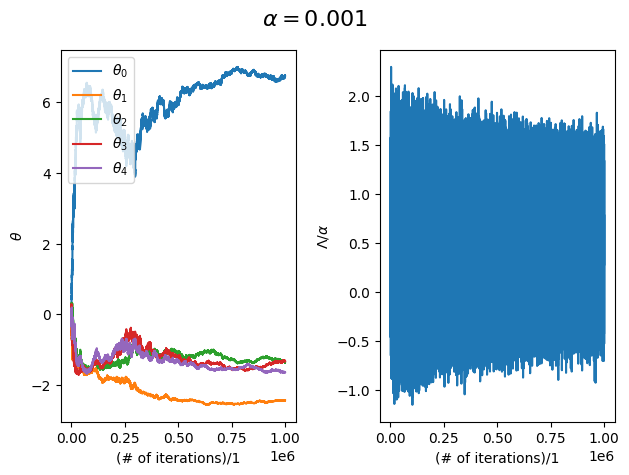

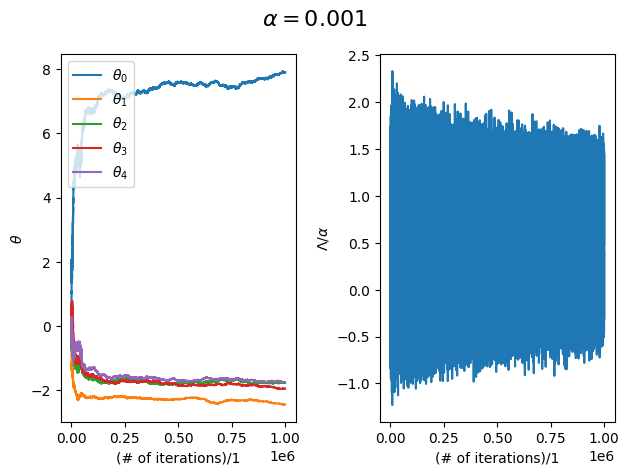

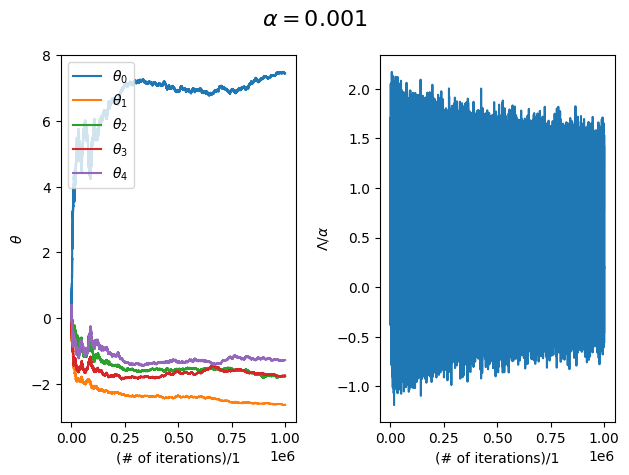

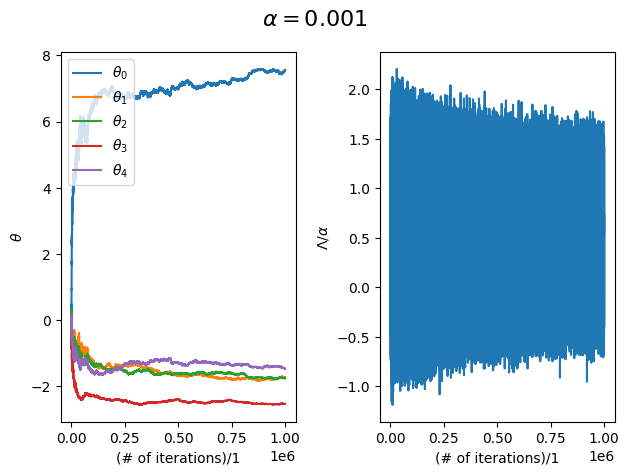

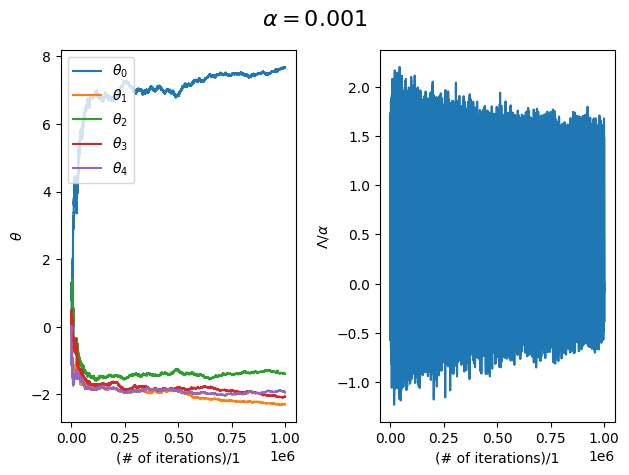

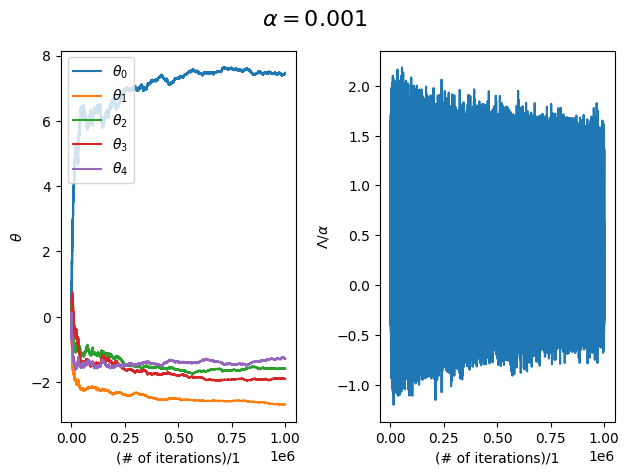

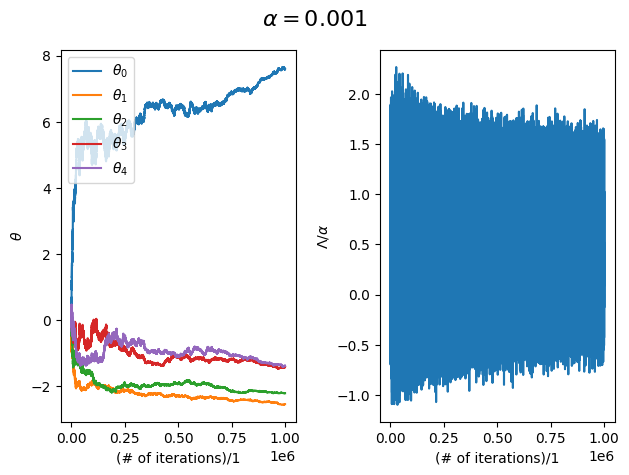

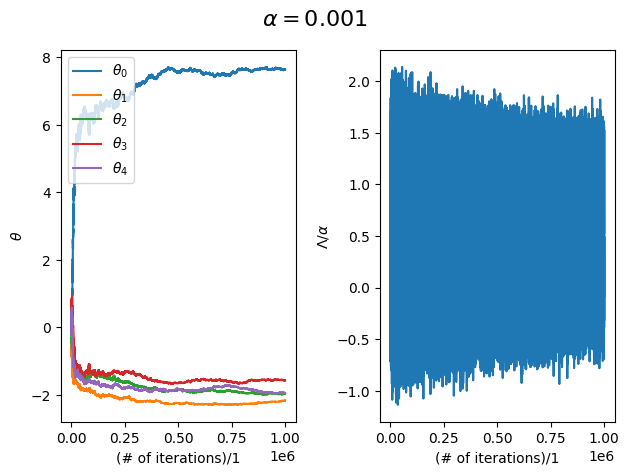

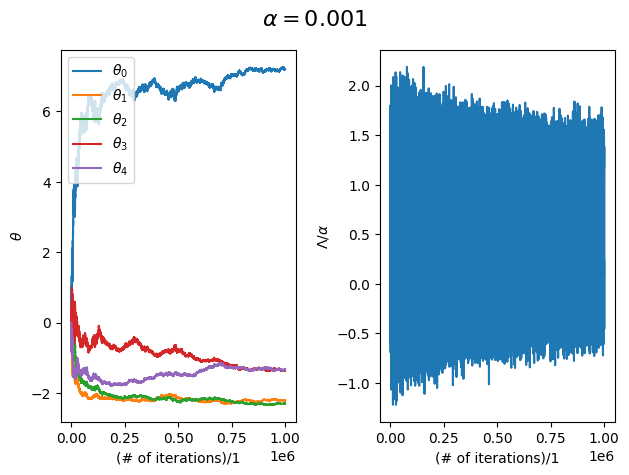

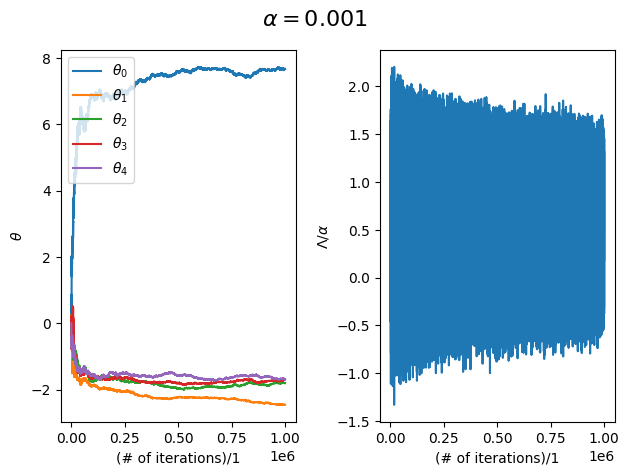

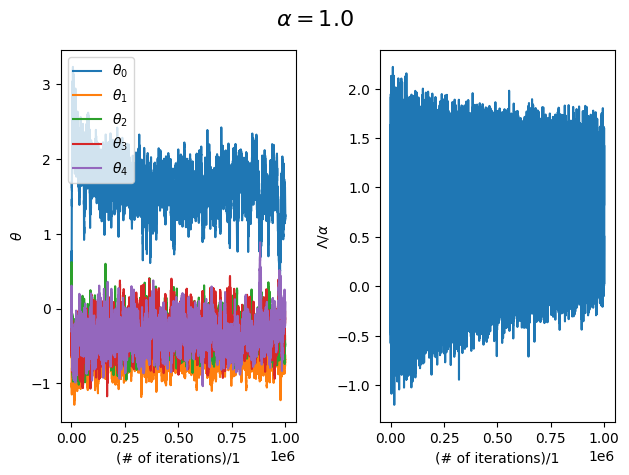

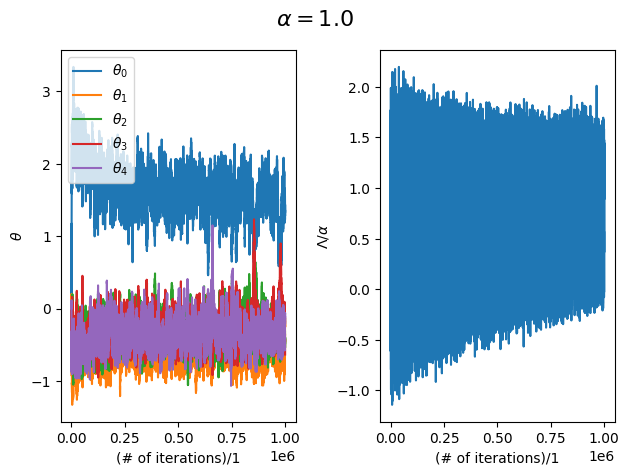

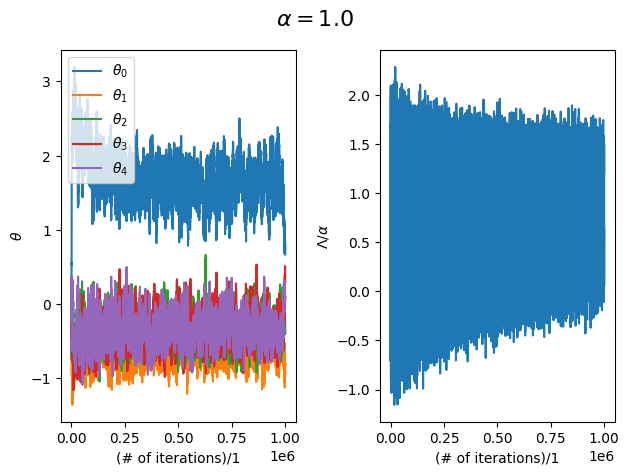

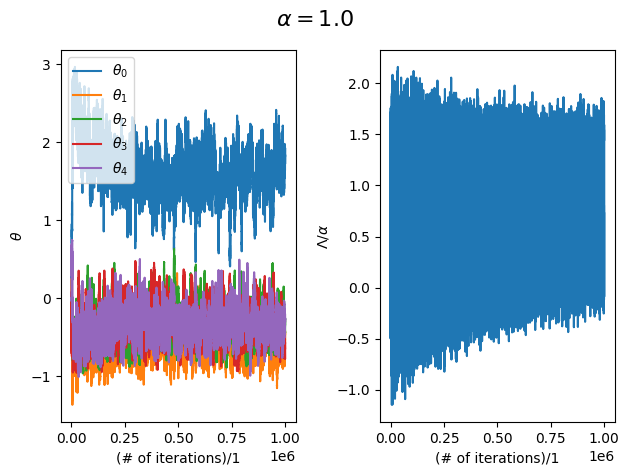

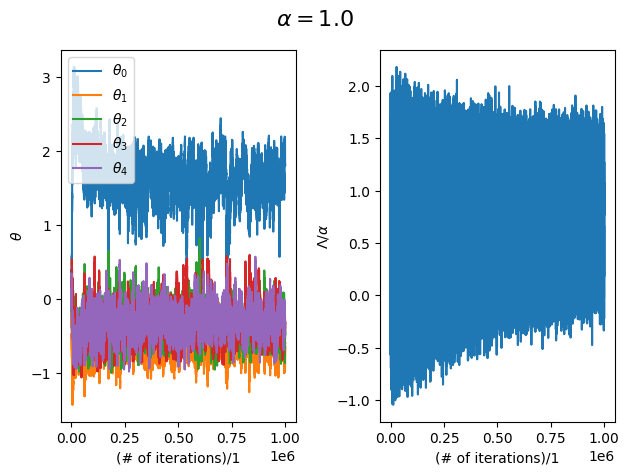

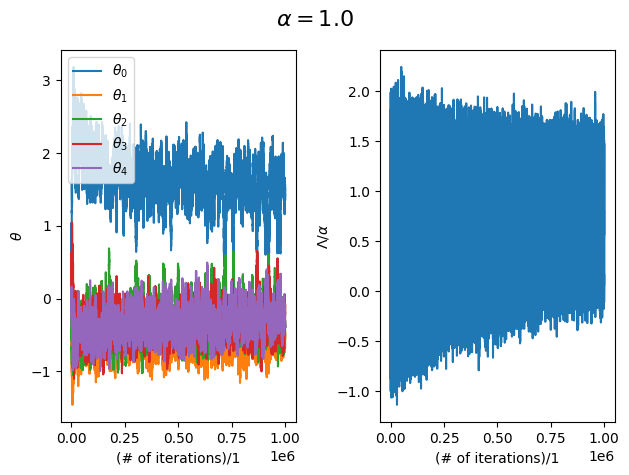

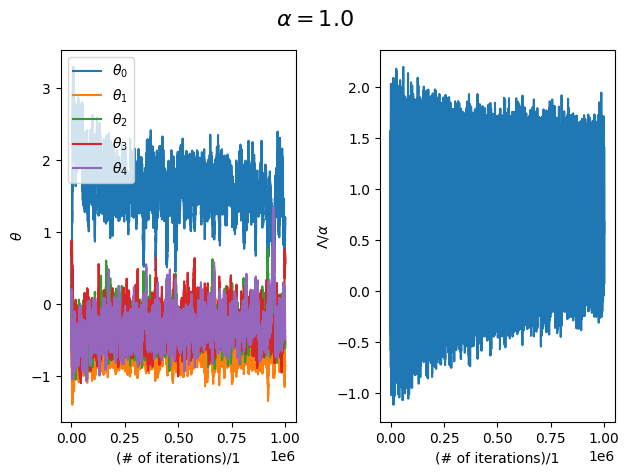

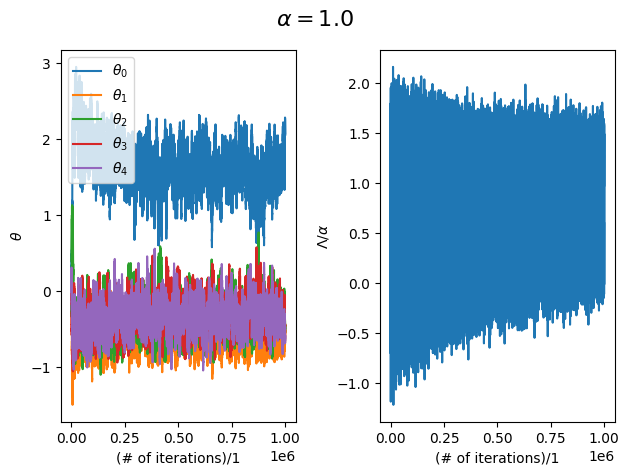

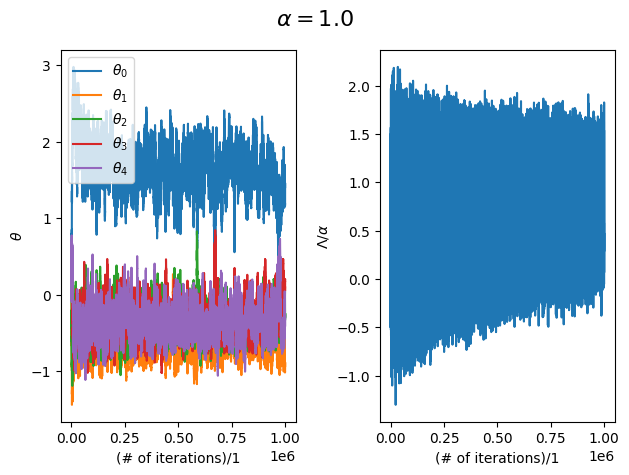

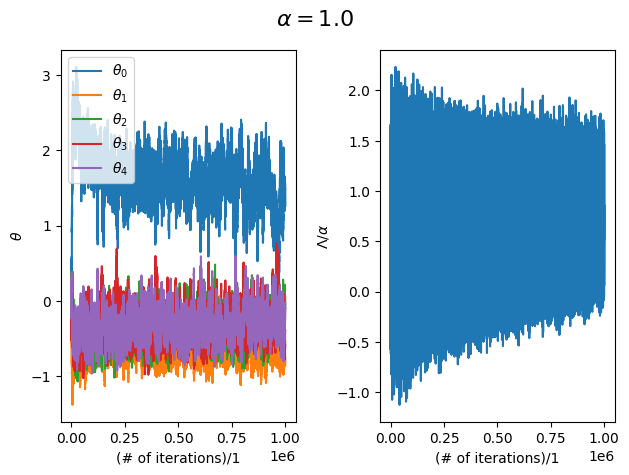

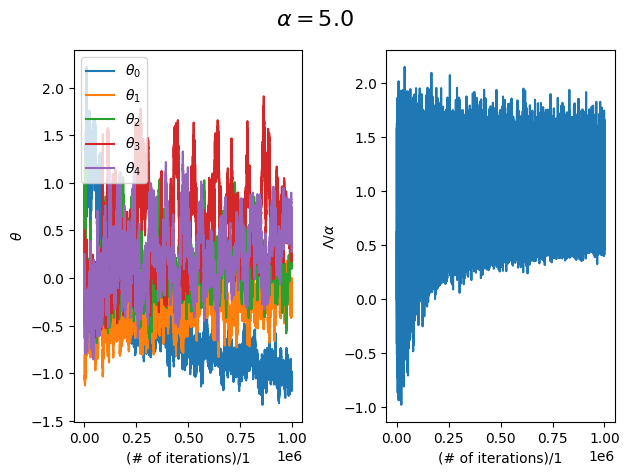

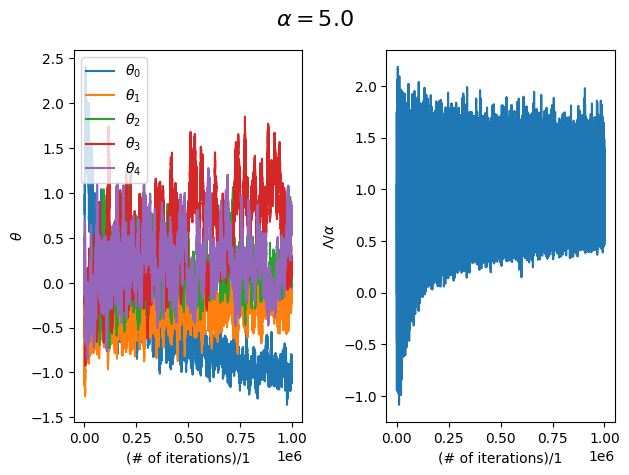

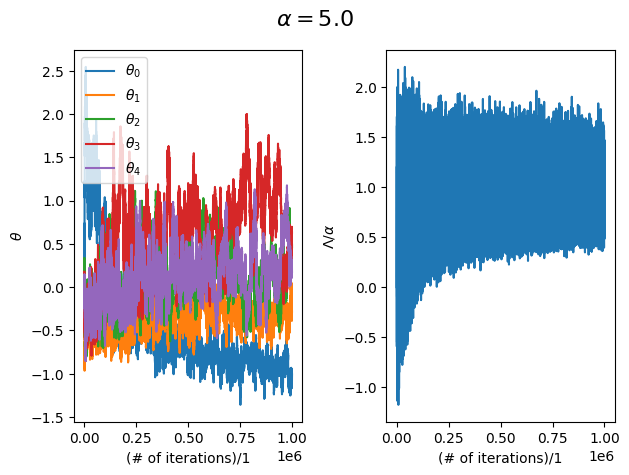

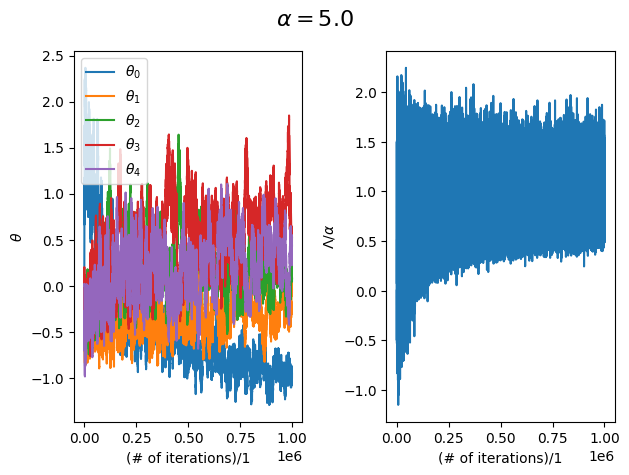

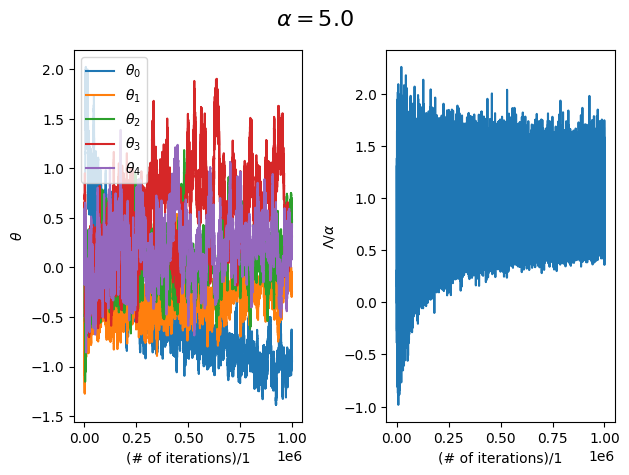

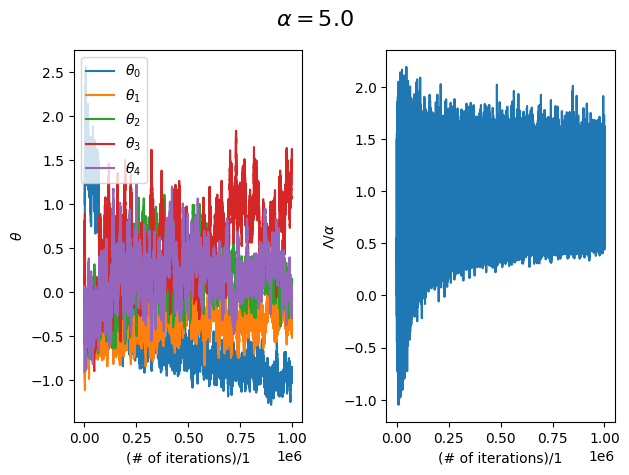

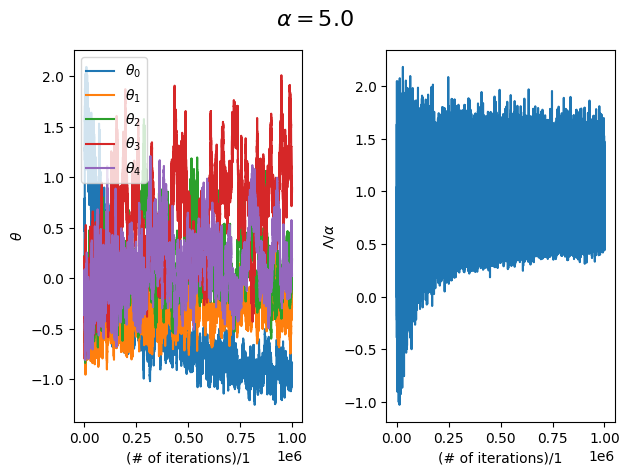

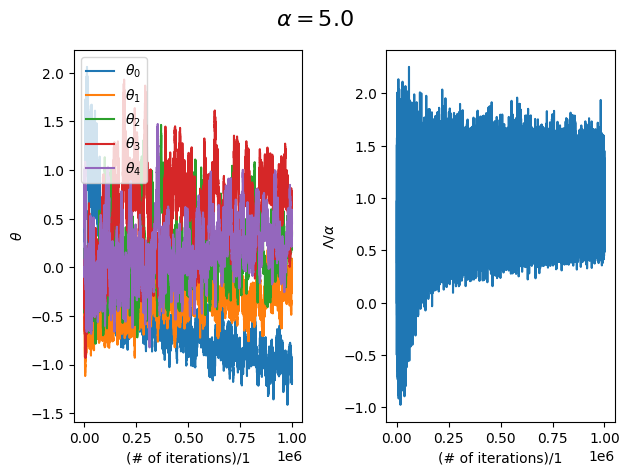

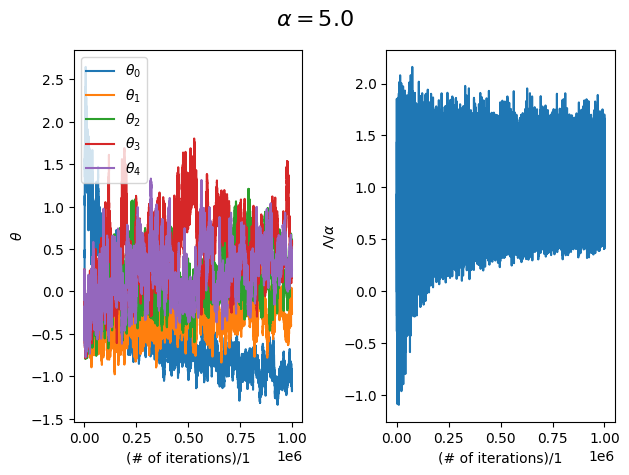

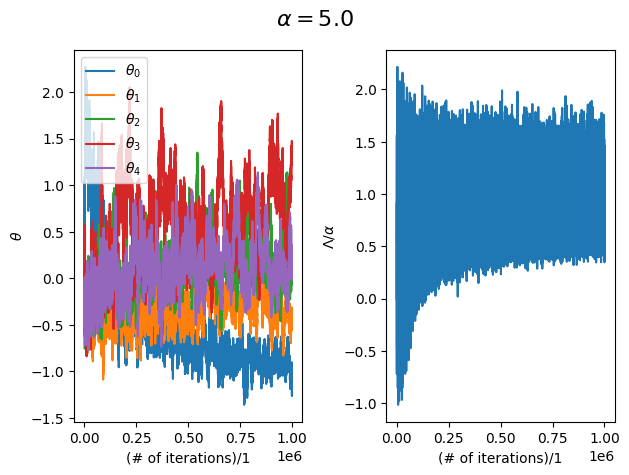

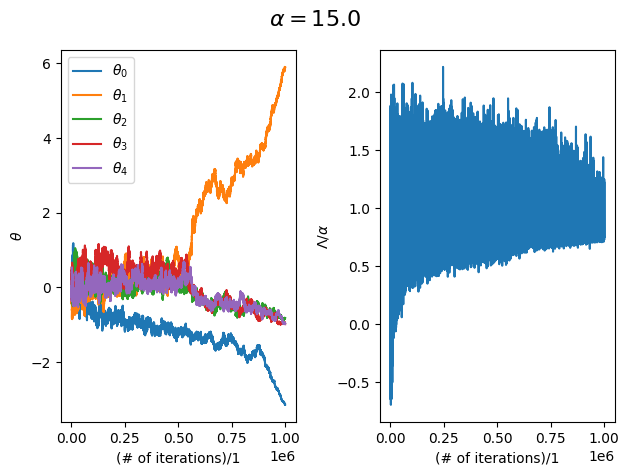

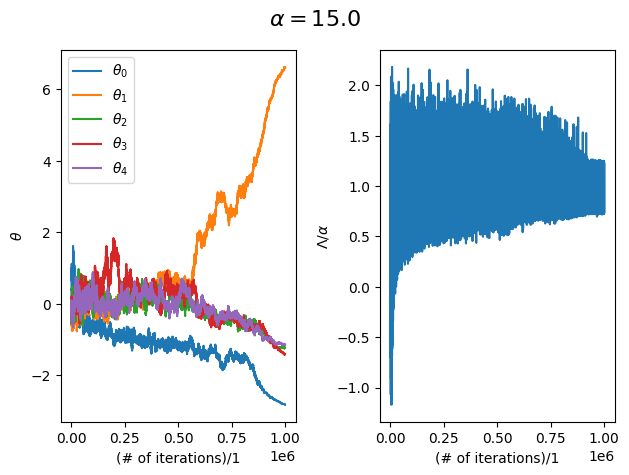

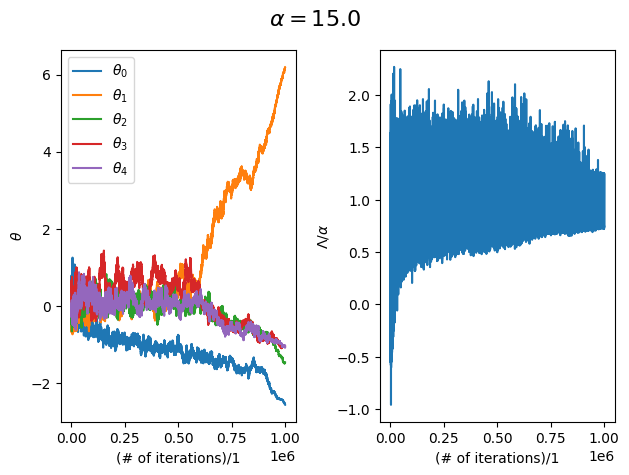

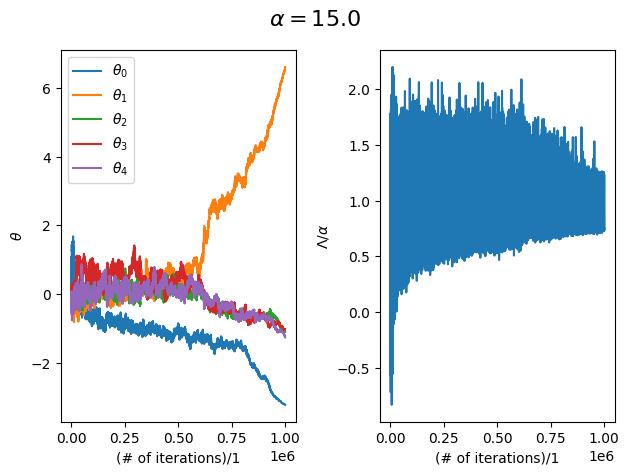

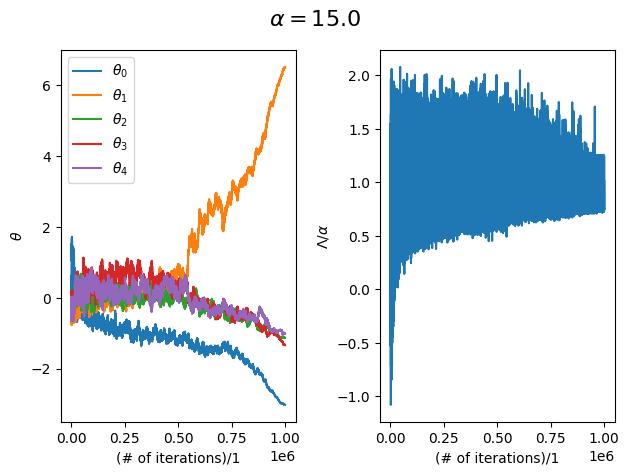

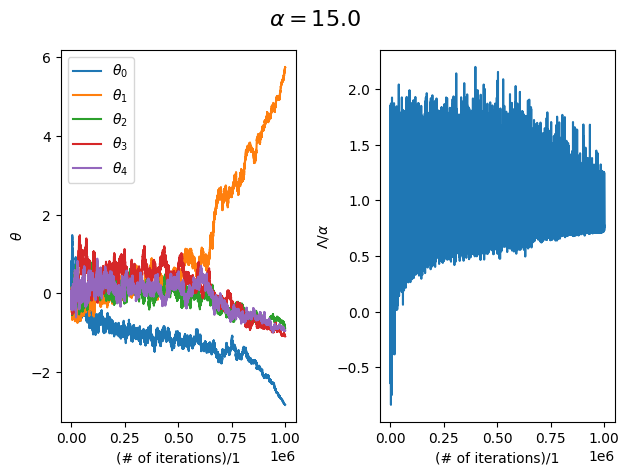

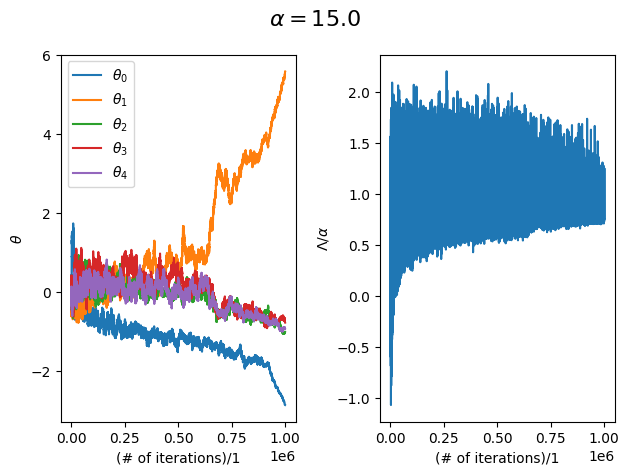

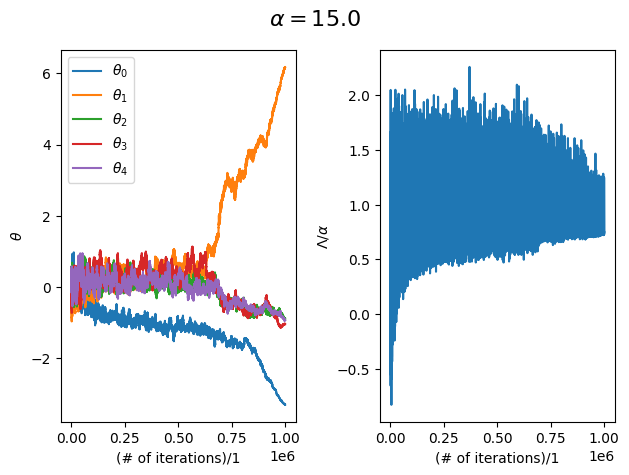

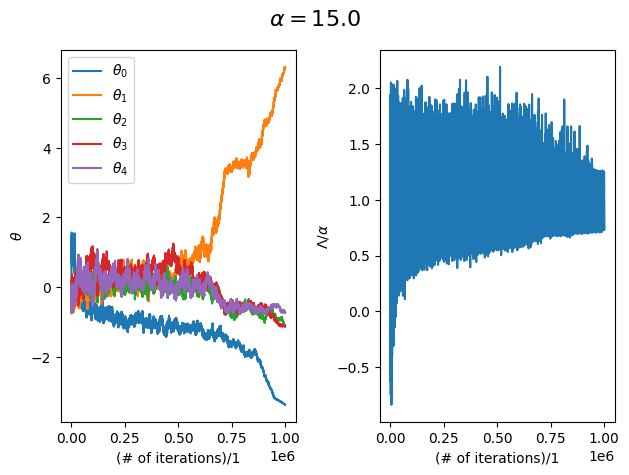

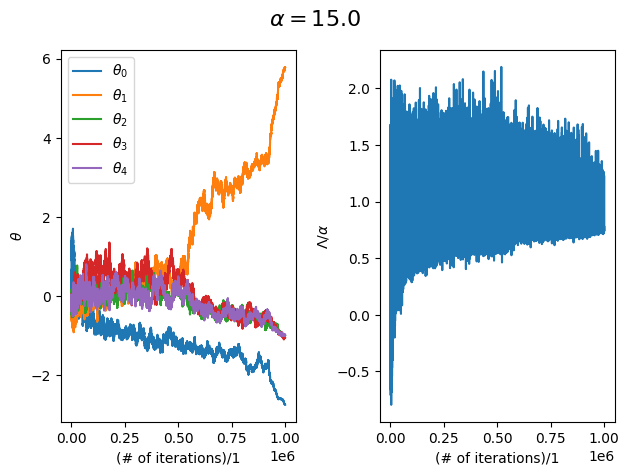

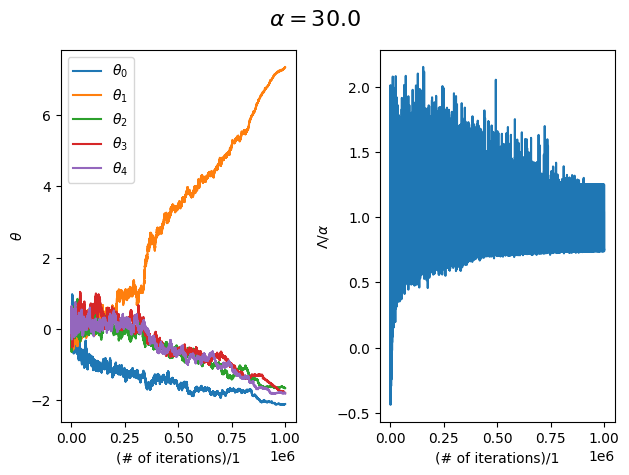

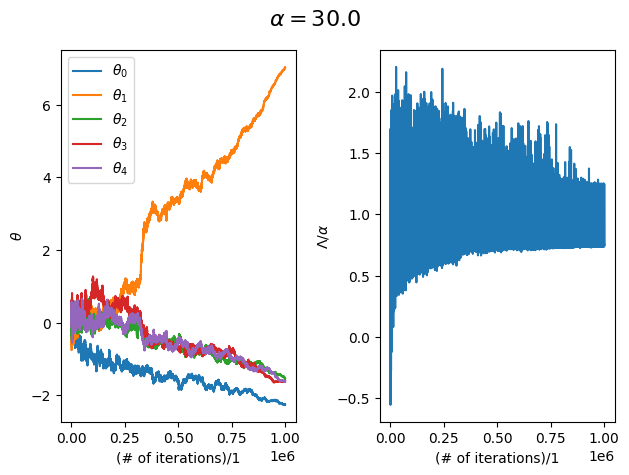

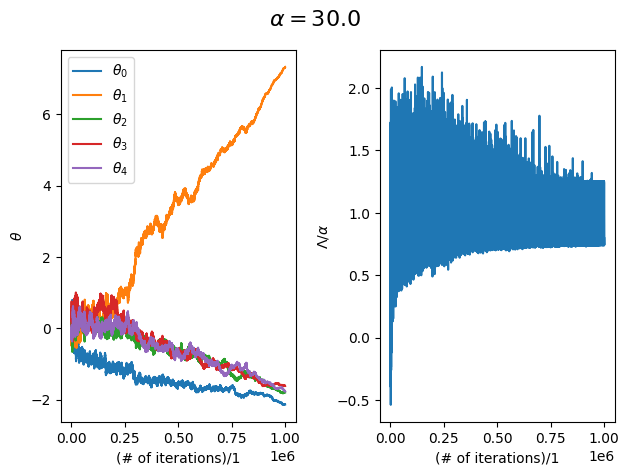

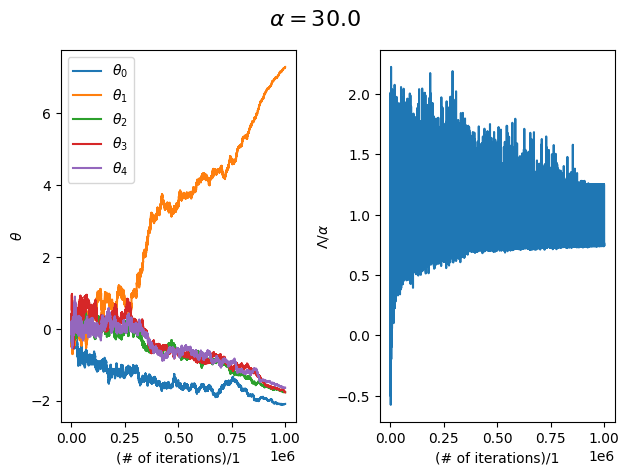

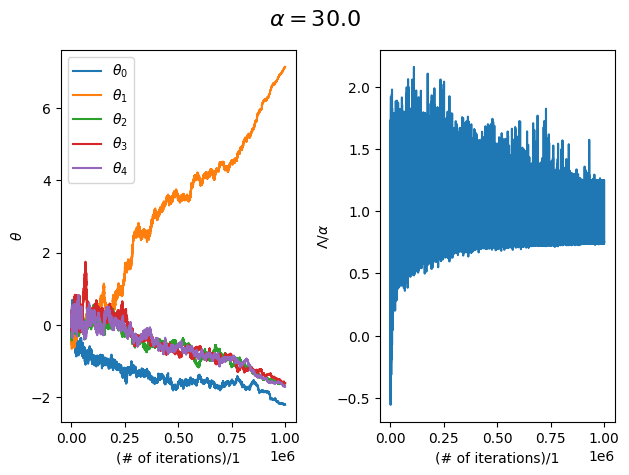

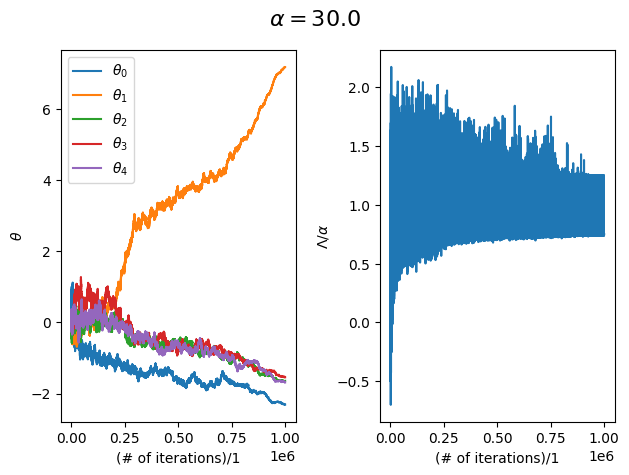

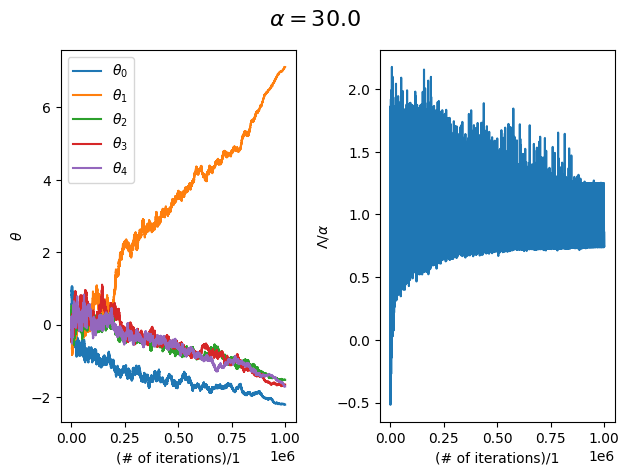

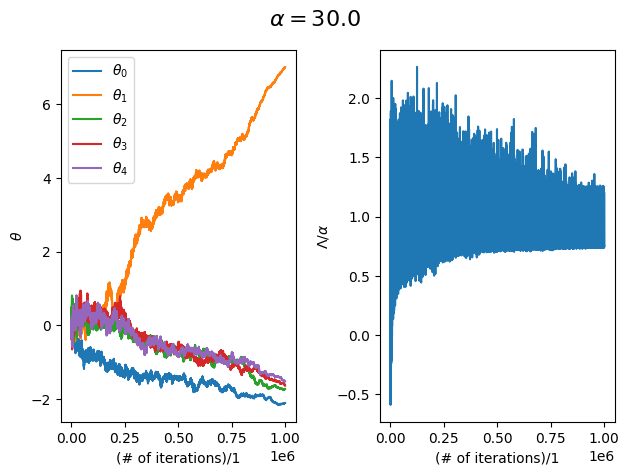

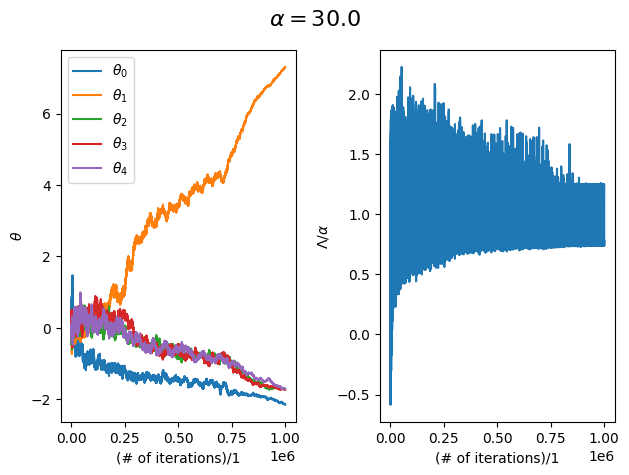

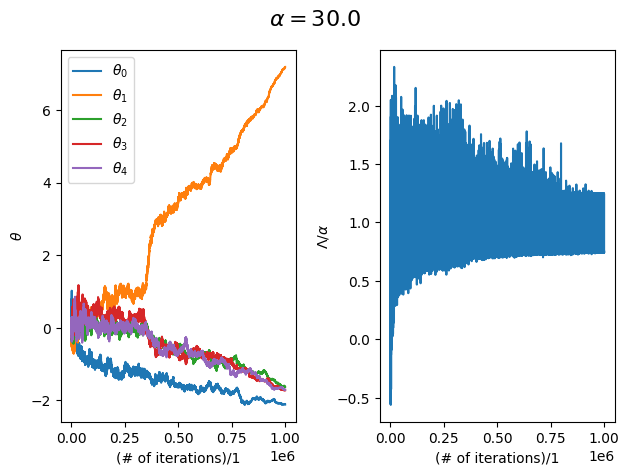

In [8]:
'''
risk factor is equal to:
        0.001 for the next 10 samples
        1 for the next 10 samples
        5 for the next 10 samples
        15 for the next 10 samples
        30 for the last 10 samples 
and eta = 20 * alpha

In this case, the algorithm updates at visits to the recurrent state.
'''

samplesize = 50

riskfactor = np.array( [0.001]*10 + [1]*10 + [5]*10 + [15]*10 + [30]*10)
scale = 20 * riskfactor


theta_0 = np.zeros(actionsize)
Lambda_0 = 0

theta_thresh = 0.01
Lambda_thresh = riskfactor / 2

recstate = 0
recurvisit = True


alg = RiskPolicyGrad(samplesize, riskfactor, dynamic, policy, likelihood, cost,\
                        theta_0, Lambda_0, theta_thresh, Lambda_thresh, recstate,\
                        recurvisit, policynorm)

theta, Lambda = alg.run(1000000,eta = scale)

Iteration Number 0 is done!
Iteration Number 100000 is done!
Iteration Number 200000 is done!
Iteration Number 300000 is done!
Iteration Number 400000 is done!
Iteration Number 500000 is done!
Iteration Number 600000 is done!
Iteration Number 700000 is done!
Iteration Number 800000 is done!
Iteration Number 900000 is done!


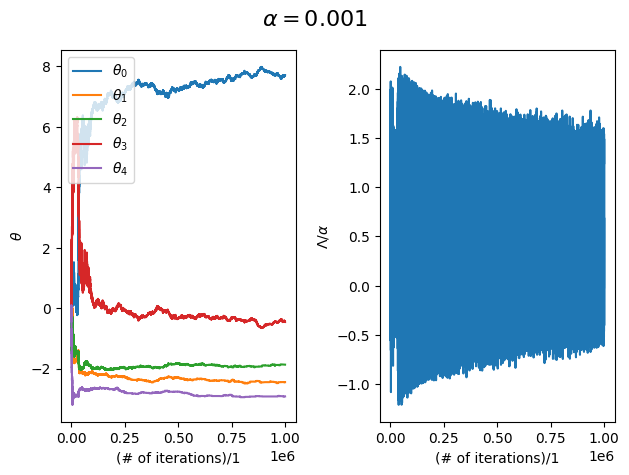

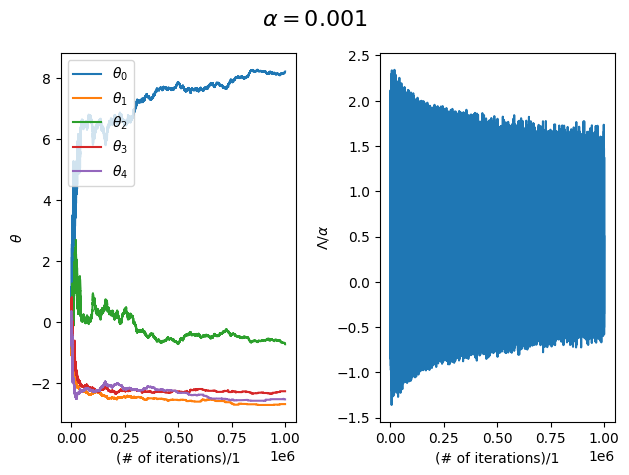

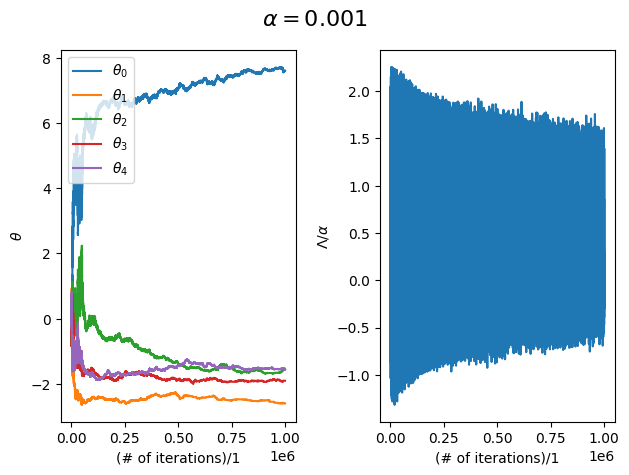

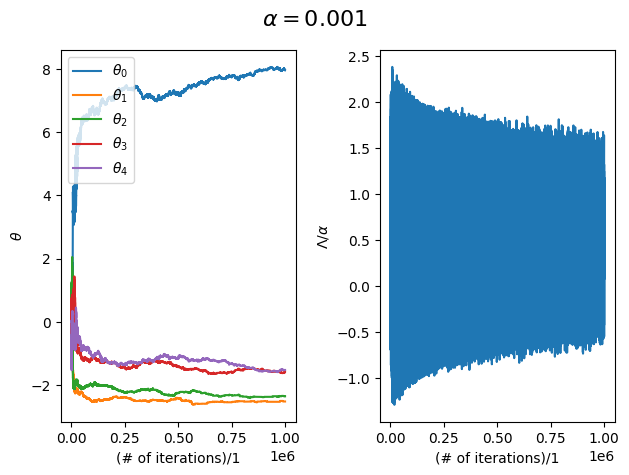

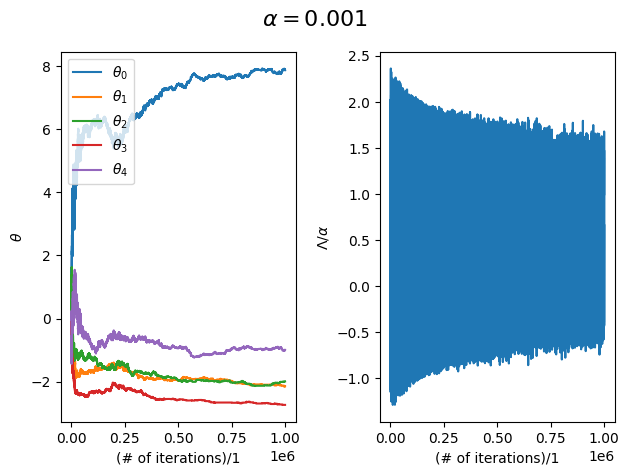

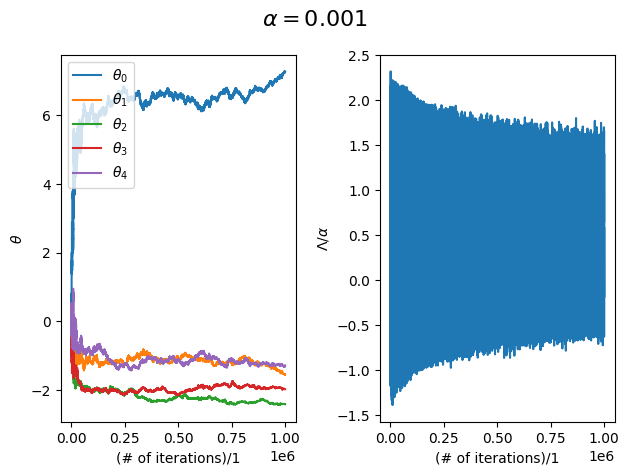

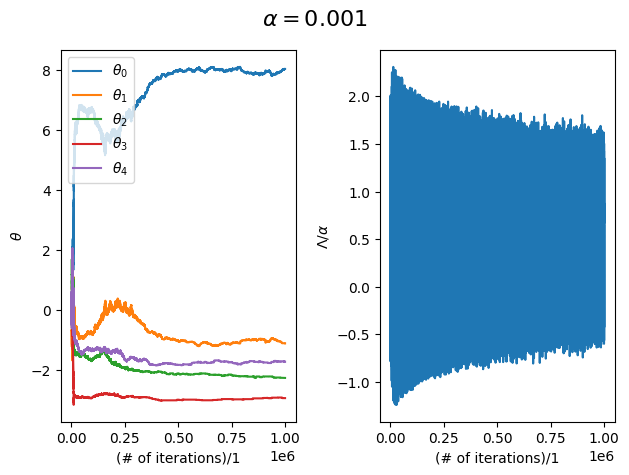

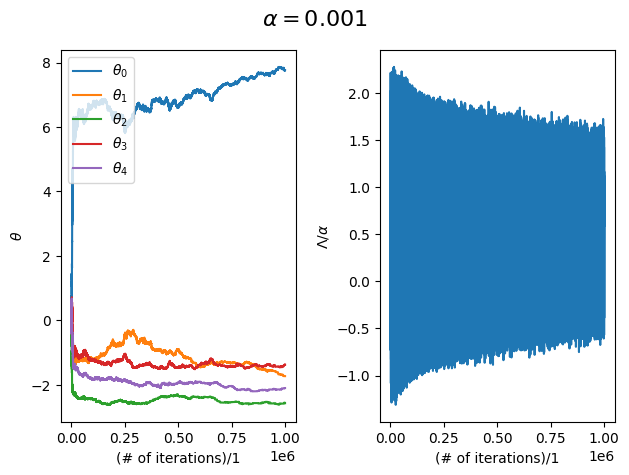

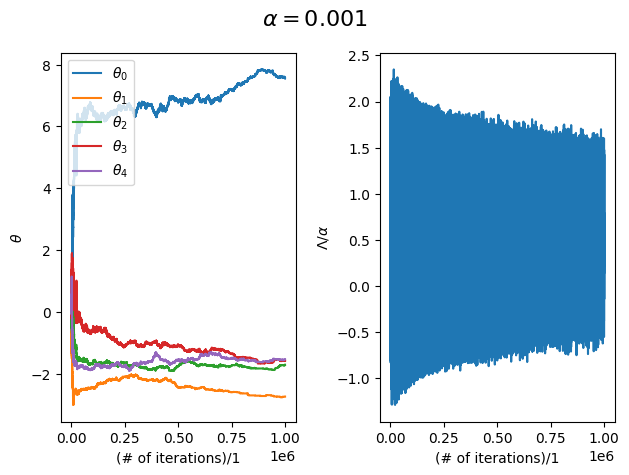

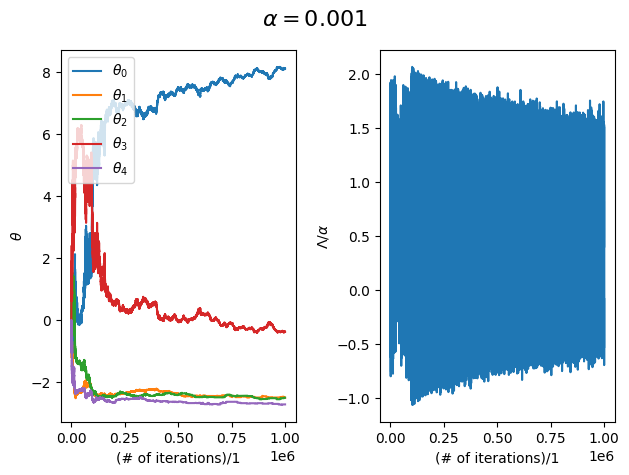

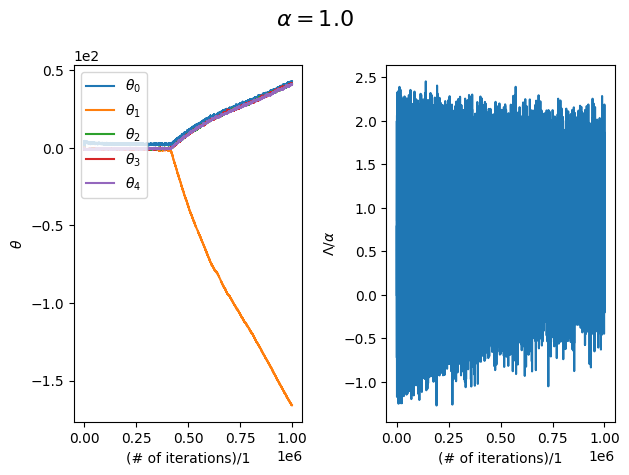

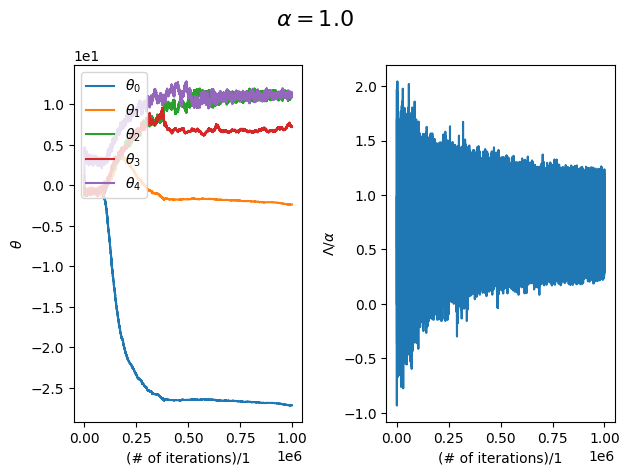

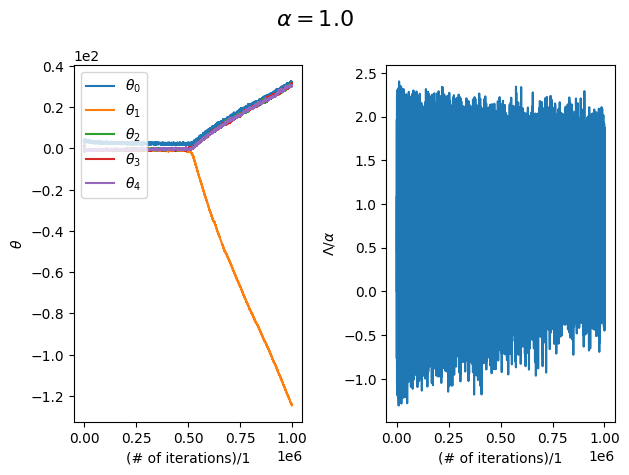

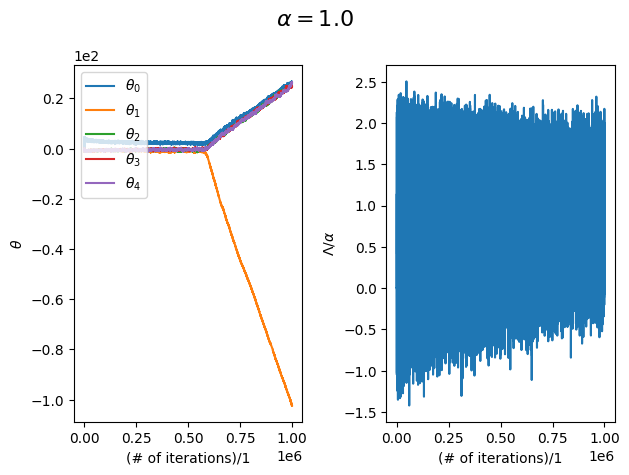

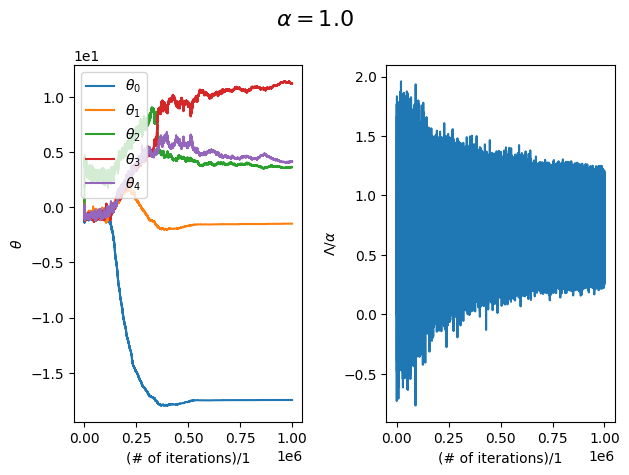

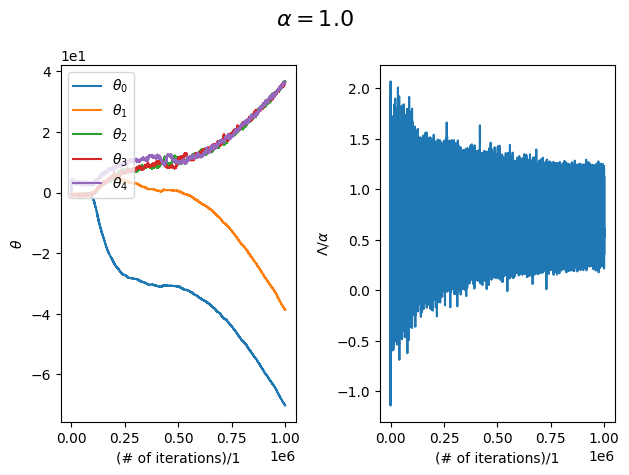

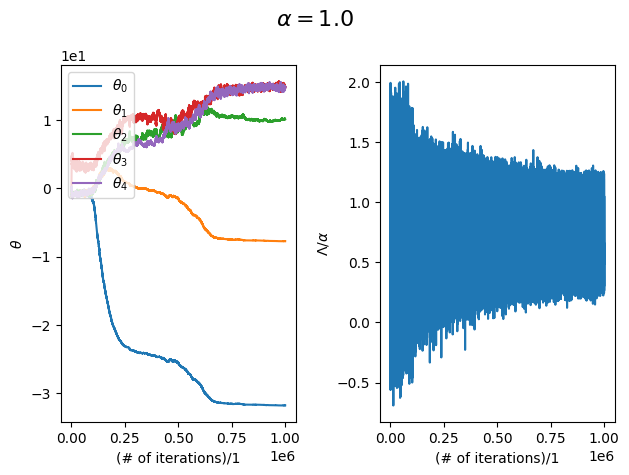

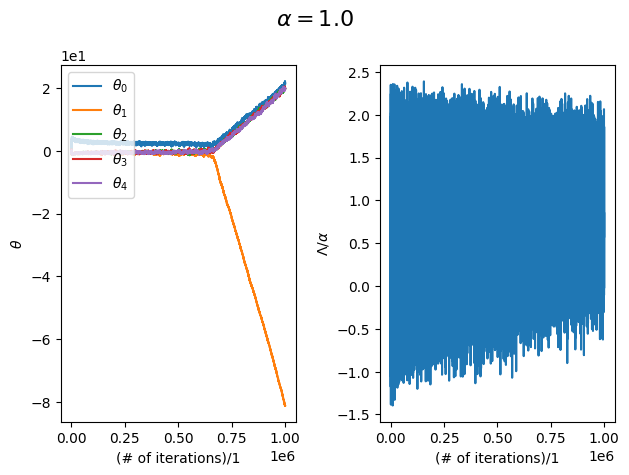

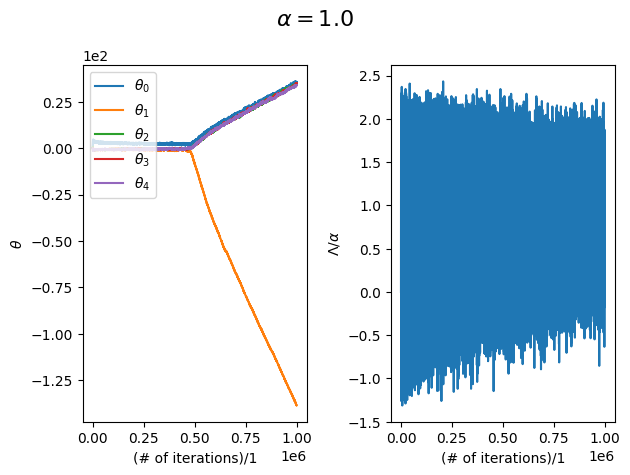

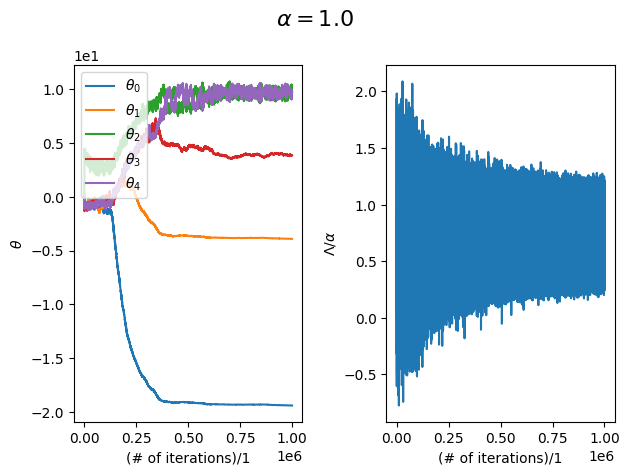

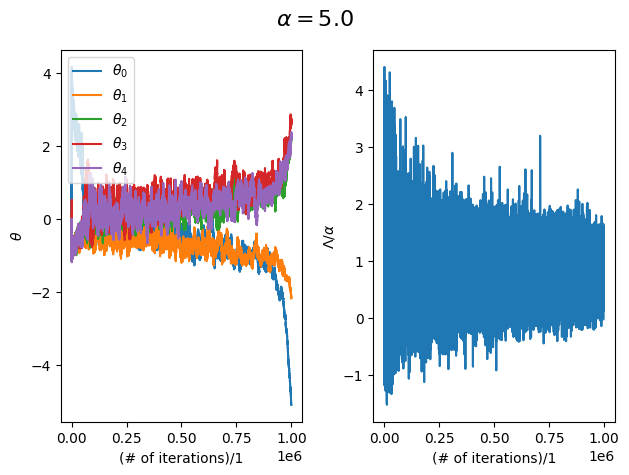

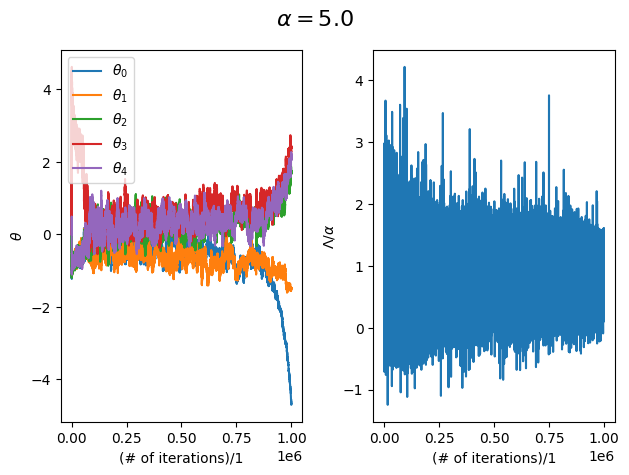

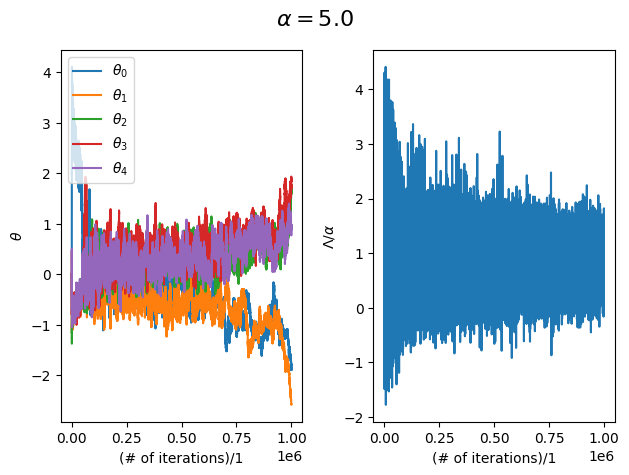

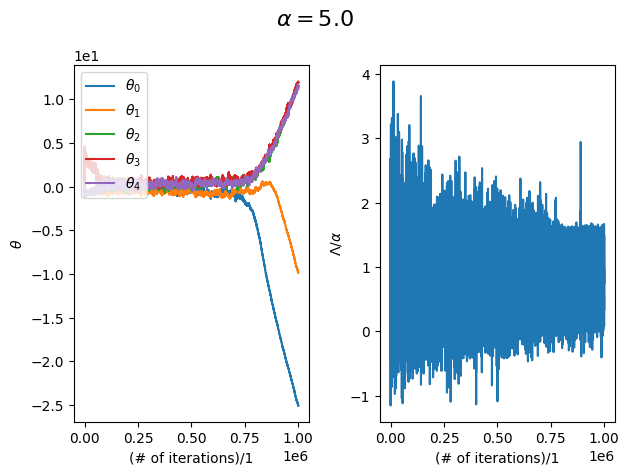

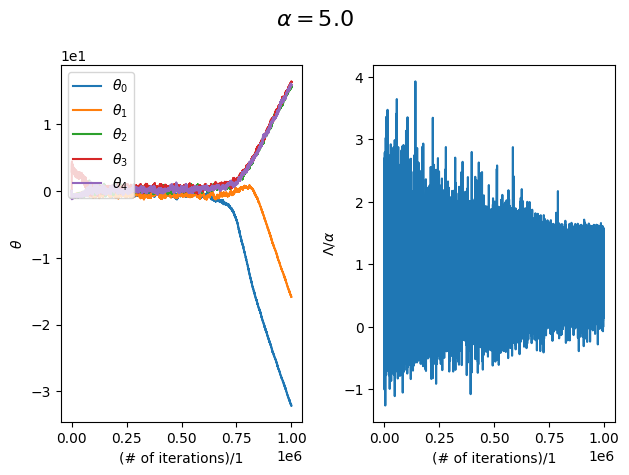

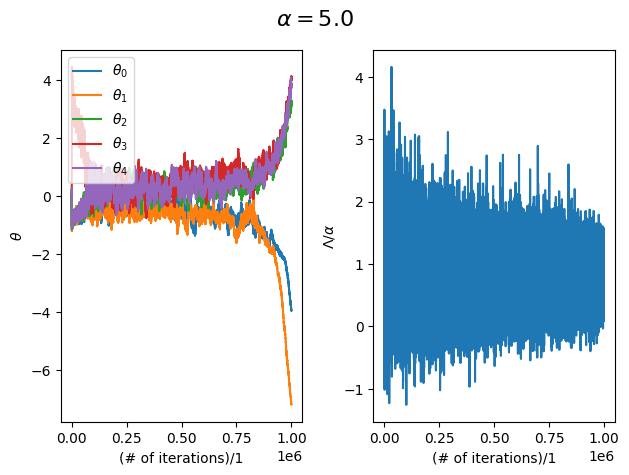

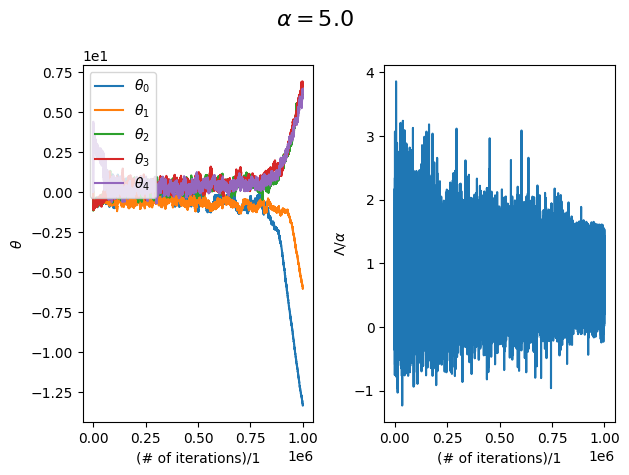

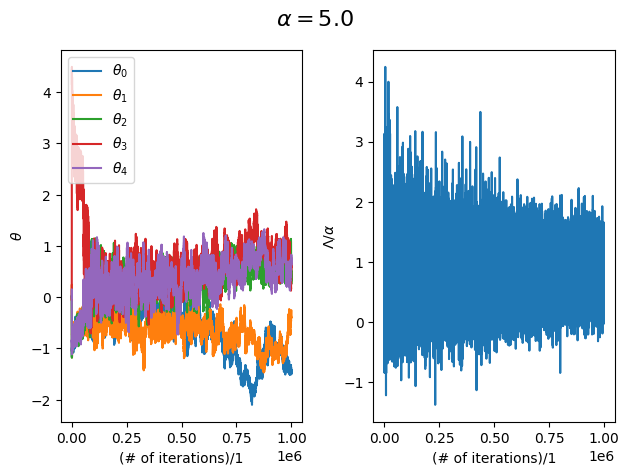

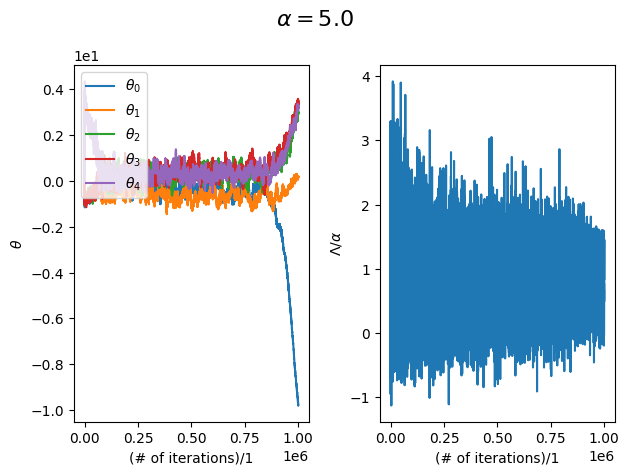

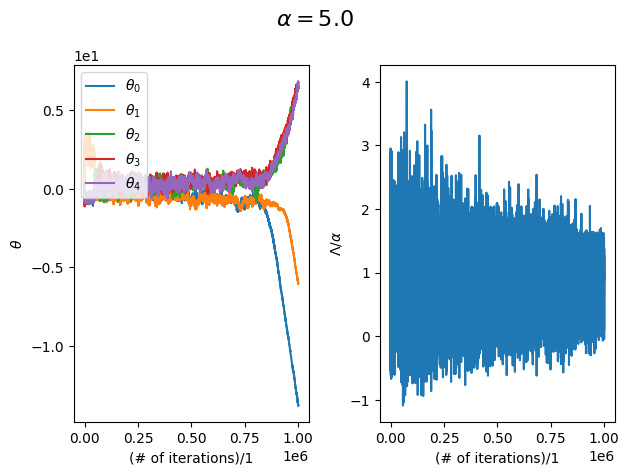

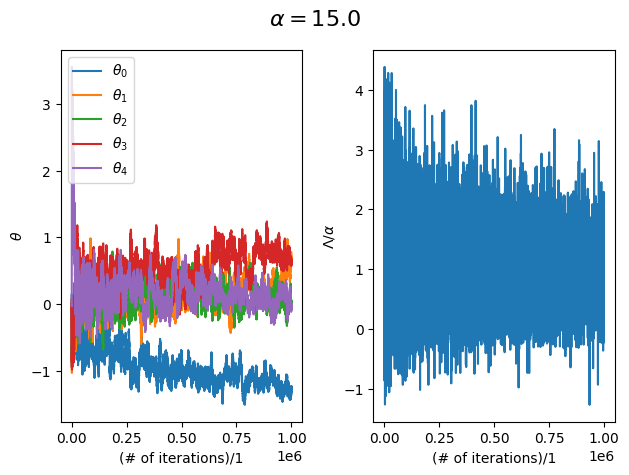

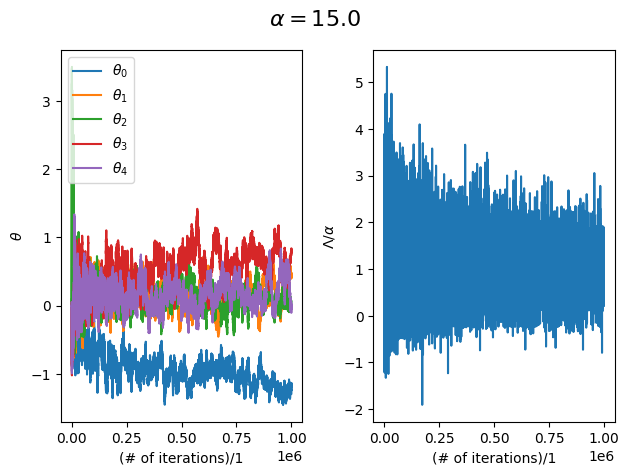

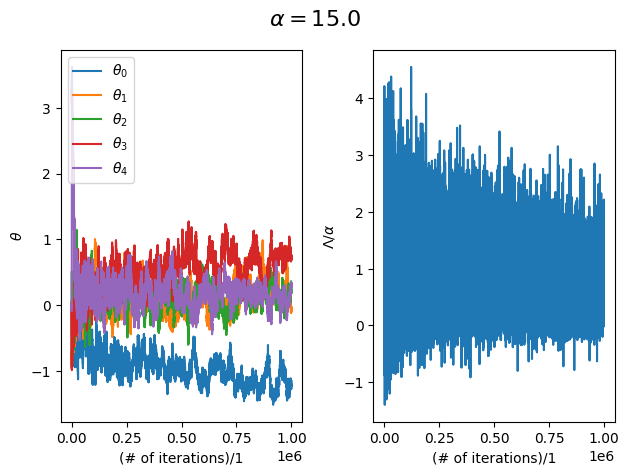

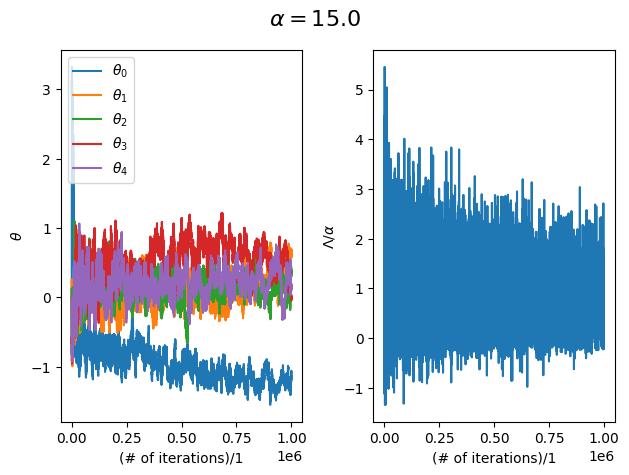

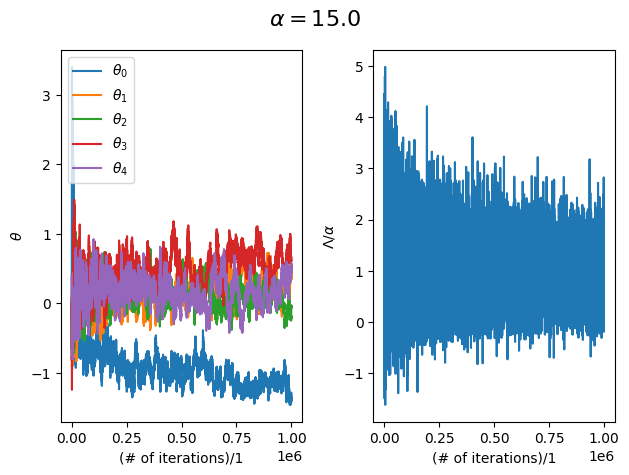

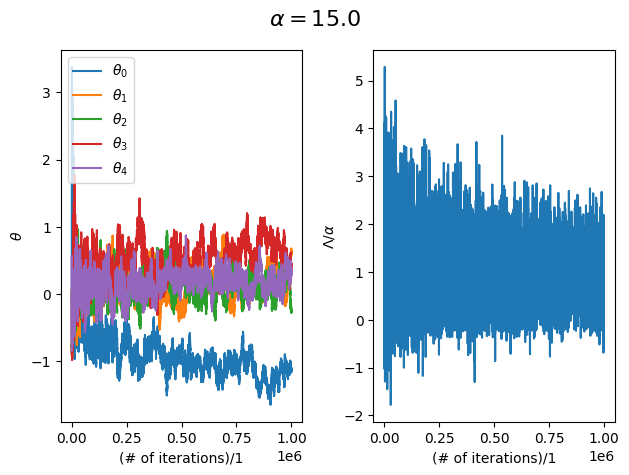

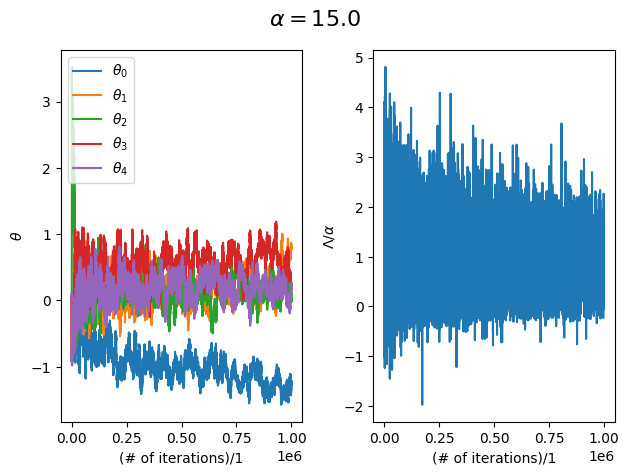

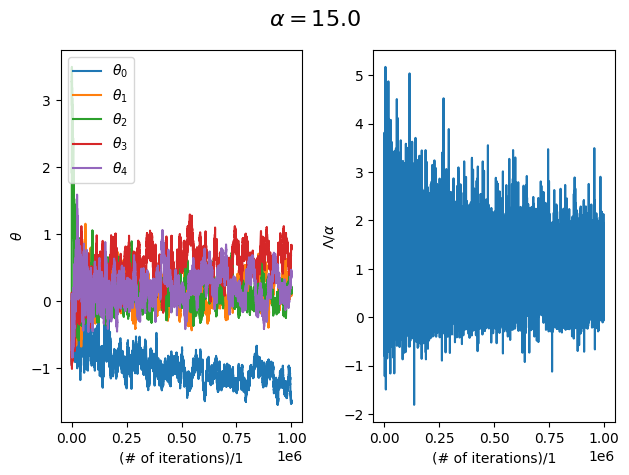

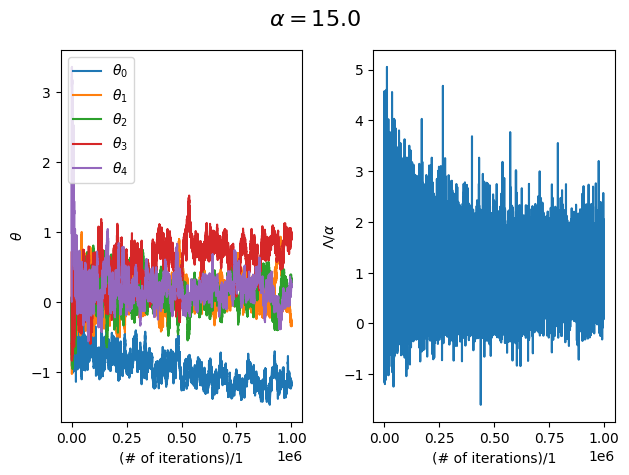

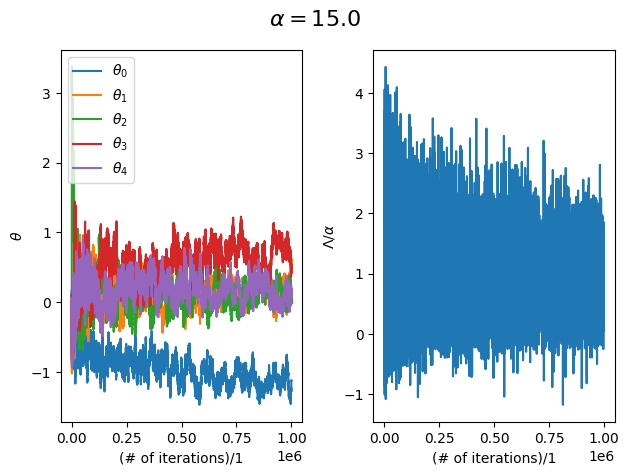

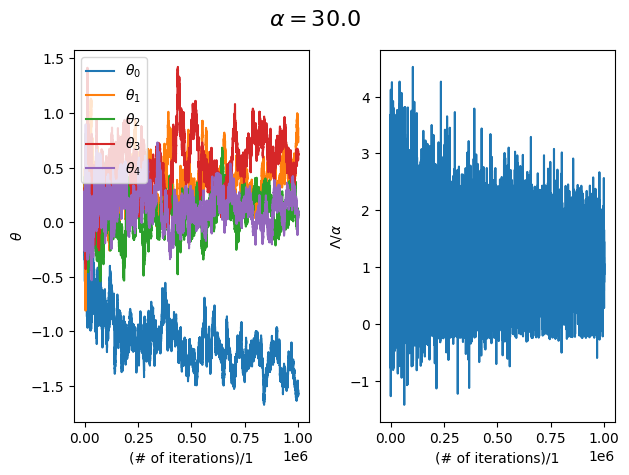

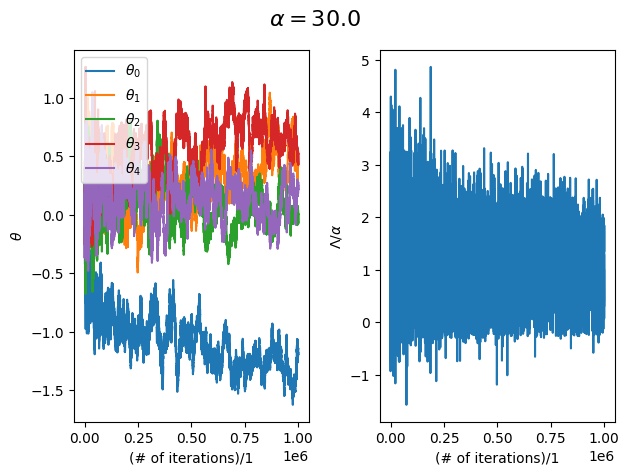

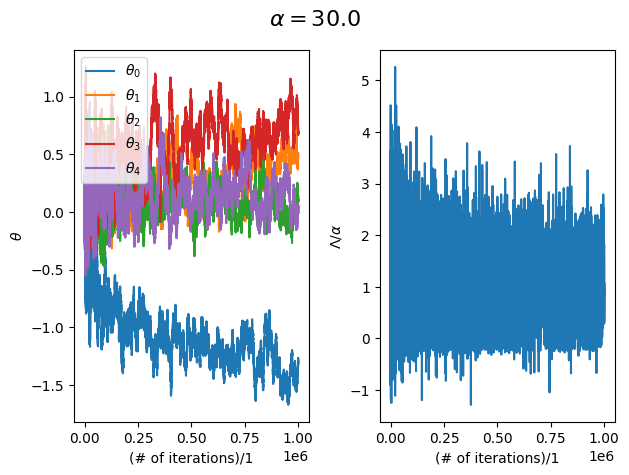

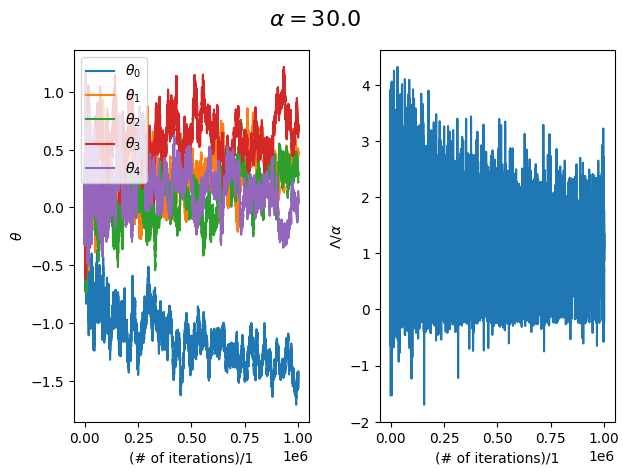

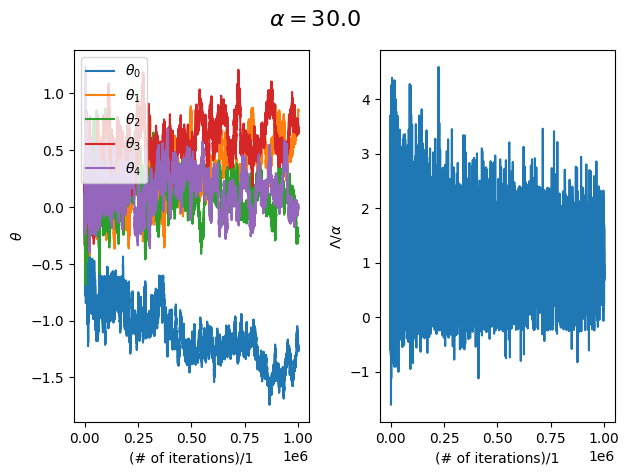

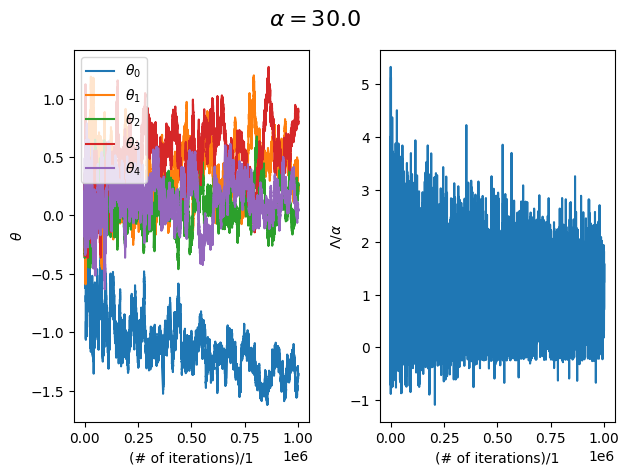

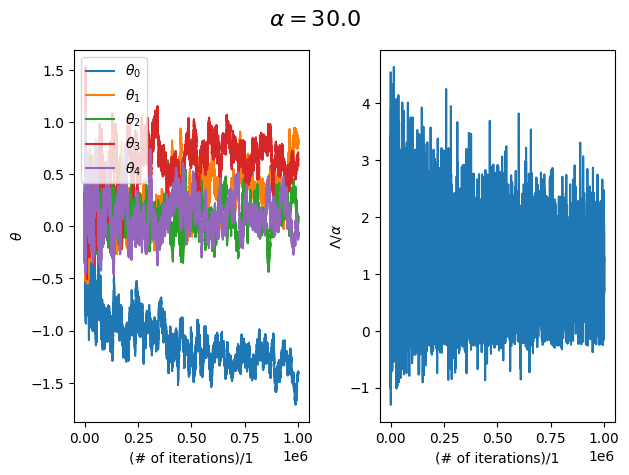

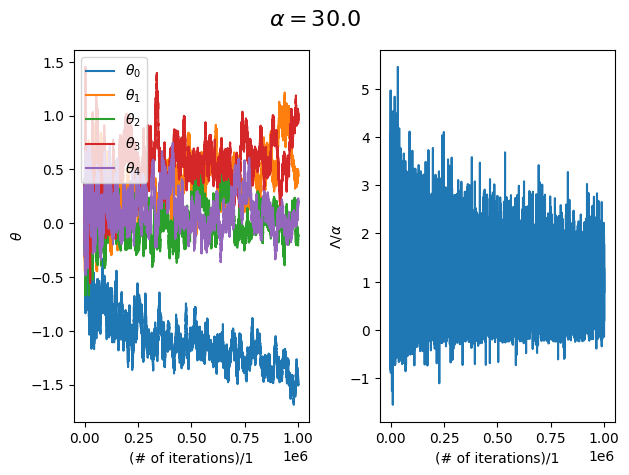

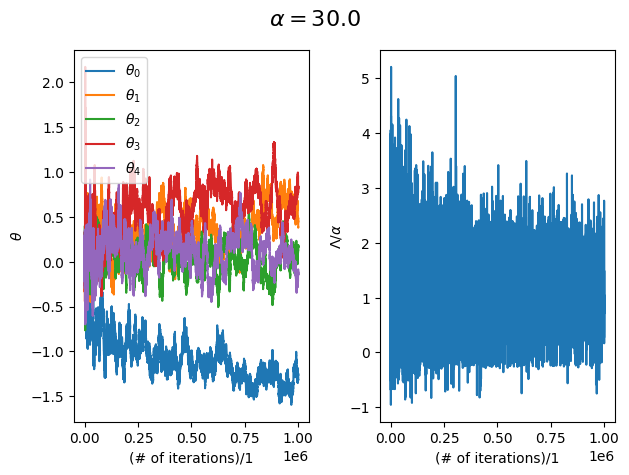

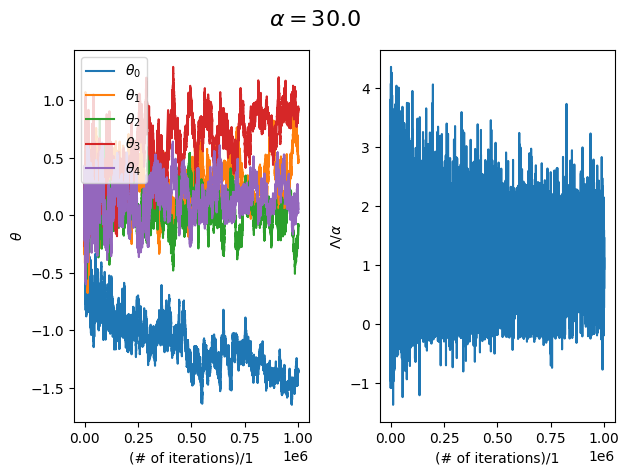

In [9]:
'''
risk factor is equal to:
        0.001 for the next 10 samples
        1 for the next 10 samples
        5 for the next 10 samples
        15 for the next 10 samples
        30 for the last 10 samples 
and eta = 20 * alpha

In this case, the algorithm updates at each iteration.
'''

samplesize = 50

riskfactor = np.array( [0.001]*10 + [1]*10 + [5]*10 + [15]*10 + [30]*10)
scale = 20 * riskfactor


theta_0 = np.zeros(actionsize)
Lambda_0 = 0

theta_thresh = 0.01
Lambda_thresh = riskfactor / 2

recstate = 0
recurvisit = False


alg = RiskPolicyGrad(samplesize, riskfactor, dynamic, policy, likelihood, cost,\
                        theta_0, Lambda_0, theta_thresh, Lambda_thresh, recstate,\
                        recurvisit, policynorm)

theta, Lambda = alg.run(1000000,eta = scale)

### Example 2: Contextual Bandit with Discrete Signal
In our second example, we consider a contextual bandit problem with the following setting:
* The state of the problem is the context
* The action of the problem is the arm that we pull
* The transition kernel P is randomly generated.
* we consider a ``soft-max policy parametrization'' where 
$$
\mu_\theta(s,a) = \frac{\exp(\theta_{a+s}\times(a+s+1))}{\sum_{a+s} \exp(\theta_{a+s}\times(a+s+1))}.
$$
* we consider a simple case where the cost of action $a$ in context $s$ is a normally distributed random variable with mean $(5a+s)/20$ and variance $20/(1+20a+s)$

#### Best Strategy
The size of the parameter space is $|\mathcal{S}|+|\mathcal{A}|$ which is much smaller than $|\mathcal{S}\times\mathcal{A}|$. Notice that the probability of choosing an action $a$ at state $s$ is related to the value of $\theta_{s+a}$. Therefore, a mixed strategy is expected to be the most effective approach, depending on the value of $\alpha$. As $\alpha \to 0$ , the coordinates of $\theta$ associaed with the best strategy follow a decreasing sequence $\theta_0 \gg \theta_1 \gg \theta_2 \gg \cdots \gg \theta_{|\mathcal{S}|+|\mathcal{A}|}$. On the other hand, as $\alpha\to\infty$, the coordinates of $\theta$ associaed with the best strategy follow an increasing sequence $\theta_0 \ll \theta_1 \ll \theta_2 \ll \cdots \ll \theta_{|\mathcal{S}|+|\mathcal{A}|}$.

In [10]:
'''
Markov Decision Process:
    dynamic(state,action) -> next_state
    cost(state,action) -> cost
    likelihood(theta,state,action) -> grad( policy(theta,state)[action] ) / policy(theta,state)[action];
    policynorm(theta) -> theta_normalized
    
Remark: to improve the speed of the algorithm, we buffer next_state for different (state, action) pairs.
        Variables used for buffering, are named as "name_buffer"
'''
actionsize = 5
statesize = 6

rng = np.random.default_rng(seed = 50)

# feature matrix
featurevec = np.zeros(shape = (statesize,actionsize))
for state,action in product(range(statesize),range(actionsize)):
    featurevec[state,action] = state + action + 1

# transition probability
TranKernel = {}
for state,action in product(range(statesize),range(actionsize)):
    TranKernel[(state,action)] = rng.uniform(0,1,size=(statesize,))
    TranKernel[(state,action)] = TranKernel[(state,action)]/np.sum(TranKernel[(state,action)])
    
# prefetch data to be used while sampling a new state
datalen_buffer = 100000
idx_buffer =  {
    (state, action): 0
    for state, action in product(range(statesize), range(actionsize))
}

nextstate_buffer = {
    (state, action): rng.choice(statesize,datalen_buffer,p = TranKernel[(state,action)])
    for state, action in product(range(statesize), range(actionsize))
}

def dynamic(state,action):
    '''
    The underlying dynamic of the MDP; 
        dynamic(state,action) -> next_state;
        the dimensions are given by:
            state.shape = (number of samples,)
            action.shape = (number of samples,)
            next_state.shape = (number of samples,)
    '''
    global TranKernel, datalen_buffer, idx_buffer, nextstate_buffer
    assert state.shape == action.shape and len(state.shape) == 1
    samplesize = state.shape[0]
    
    # check whether we need more data
    for sample in range(samplesize):
        if idx_buffer[(state[sample],action[sample])] + samplesize >= datalen_buffer:
            idx_buffer[(state[sample],action[sample])] = 0
            nextstate_buffer[(state[sample],action[sample])] = \
                rng.choice(statesize,datalen_buffer,p = TranKernel[(state[sample],action[sample])])
        
    # use prefetch data to determine the next state
    nextstate = []
    for sample in range(samplesize):
        nextstate = nextstate + [nextstate_buffer[(state[sample],action[sample])][idx_buffer[(state[sample],action[sample])]]]
        idx_buffer[(state[sample],action[sample])] += 1
    
    return np.array(nextstate).reshape(samplesize)
    
def cost(state,action):
    '''
    The one-step cost function;
        cost(state,action) -> cost;
        the dimensions are given by:
            state.shape = (number of samples,)
            action.shape = (number of samples,)
            cost.shape = (1,number of samples)
    '''
    assert state.shape == action.shape and len(state.shape) == 1
    samplesize = state.shape[0]
    
    # generate cost: the cost is distributed as N( (state + action)/2 , 1/(state + action + 1))
    randnum = rng.normal(size = samplesize)
    mean = (state+10*action)/100
    std = np.sqrt(100/( (state + 100*action)+ 1))
    return np.array( mean + std * randnum ).reshape(1,samplesize)

def policy(theta,state):
    '''
    The underlying policy parametrization;
        policy(theta,state) -> next_action; 
        the dimensions are given by:
            theta.shape = (number of samples, dimension of parameter)
            state.shape = (number of samples,)
            next_action.shape = (number of samples,)
    '''
    global actionsize, featurevec
    assert state.shape[0] == theta.shape[0] and len(state.shape) == 1 and len(theta.shape) == 2
    samplesize = state.shape[0]
    
    # generate the policy distributions for the input parameters
    exponent = theta[np.reshape(np.arange(samplesize),(samplesize,1)), state.reshape(samplesize,1) + np.arange(actionsize)] * featurevec[state,:]
    mu_theta = np.exp(exponent-np.max(exponent,axis = 1).reshape(samplesize,1)) / np.reshape(np.sum(np.exp(exponent - np.max(exponent,axis = 1).reshape(samplesize,1)),axis=1),(samplesize,1))

    # check the shape of mu_theta
    assert mu_theta.shape == (samplesize, actionsize)
    
    # realize the next action
    nextaction = []
    for sample in range(samplesize):
        nextaction = nextaction + [rng.choice(actionsize, 1, p= mu_theta[sample,:])]    

    return np.array(nextaction).reshape(samplesize)

def likelihood(theta,state,action):
    '''
    The likelihood ratio of the policy with respect to the parameter theta; 
        likelihood(theta,state,action) -> grad( policy(theta,state)[action] ) / policy(theta,state)[action];
        the dimensions are given by:
            theta.shape = (number of samples, dimension of parameter)
            state.shape = (number of samples,)
            action.shape = (number of samples,)
            grad.shape = (number of samples, dimension of parameter)
    '''
    assert state.shape == action.shape and state.shape[0] == theta.shape[0] and len(state.shape) == 1 and len(theta.shape) == 2
    samplesize = state.shape[0]
    paramsize = theta.shape[1]
    
    # generate the policy distributions for the input parameters
    exponent = theta[np.reshape(np.arange(samplesize),(samplesize,1)),state.reshape(samplesize,1) + np.arange(actionsize)] * featurevec[state,:]
    mu_theta = np.exp(exponent-np.max(exponent,axis = 1).reshape(samplesize,1)) / np.reshape(np.sum(np.exp(exponent - np.max(exponent,axis = 1).reshape(samplesize,1)),axis=1),(samplesize,1))
    # initial the likelihood matrix
    
    L = -1 * mu_theta
    # adjust the likelihood matrix based on the actions that we have taken for each sample
    for sample, sampleaction in enumerate(action): L[sample,sampleaction] += 1
    L = L * featurevec[state,:]
    
    L_tot = np.zeros(shape = (samplesize,paramsize))
    L_tot[np.reshape(np.arange(samplesize),(samplesize,1)),state.reshape(samplesize,1) + np.arange(actionsize)] = L
    
    
    return np.reshape(L_tot,(samplesize, paramsize))

def policynorm(theta):
    '''
    A function that normalizes the policy parameter theta while keeping the policy the same;
        policynorm(theta) -> theta_normalized
        the dimensions are given by:
            theta.shape = (number of samples, dimension of parameter)
            theta_normalized.shape = (number of samples, dimension of parameter)
    '''
    assert len(theta.shape) == 2
    samplesize = theta.shape[0]
    paramsize = theta.shape[1]

    return theta - np.reshape(np.reshape(np.mean(theta * (1+np.arange(paramsize)),axis=1),(samplesize,1))/ (1+np.arange(paramsize)),(samplesize,paramsize))

We consider the following two cases:
* Case 1: $\alpha = 0.00001$ and $\eta = 20 \alpha$
* Case 2: $\alpha = 0.1$ and $\eta = 20 \alpha$
* Case 3: $\alpha = 1$ and $\eta = 20 \alpha$
* Case 4: $\alpha = 15$ and $\eta = 20 \alpha$
* Case 5: $\alpha = 30$ and $\eta = 20 \alpha$

We explore two scenarios in here: one where the algorithm updates at visits to the recurrent state, and another where it updates at each iteration.

In [ ]:
'''
risk factor is equal to:
        0.00001 for the next 10 samples
        0.1 for the next 10 samples
        1 for the next 10 samples
        15 for the next 10 samples
        30 for the last 10 samples 
and eta = 20 * alpha

In this case, the algorithm updates at visits to the recurrent state.
'''

samplesize = 50

riskfactor = np.array( [0.00001]*10+ [0.1]*10 + [1]*10 + [15]*10 + [30]*10)
scale = 20 * riskfactor


theta_0 = np.zeros(actionsize+statesize-1)
Lambda_0 = 0

theta_thresh = 0.01
Lambda_thresh = riskfactor / 2

recstate = 0
recurvisit = True


alg = RiskPolicyGrad(samplesize, riskfactor, dynamic, policy, likelihood, cost,\
                        theta_0, Lambda_0, theta_thresh, Lambda_thresh, recstate,\
                        recurvisit, policynorm)

theta, Lambda = alg.run(1000000,eta = scale)

In [ ]:
'''
risk factor is equal to:
        0.00001 for the next 10 samples
        0.1 for the next 10 samples
        1 for the next 10 samples
        15 for the next 10 samples
        30 for the last 10 samples 
and eta = 20 * alpha

In this case, the algorithm updates at visits to the recurrent state.
'''

samplesize = 50

riskfactor = np.array( [0.00001]*10+ [0.1]*10 + [1]*10 + [15]*10 + [30]*10)
scale = 20 * riskfactor


theta_0 = np.zeros(actionsize+statesize-1)
Lambda_0 = 0

theta_thresh = 0.01
Lambda_thresh = riskfactor / 2

recstate = 0
recurvisit = False


alg = RiskPolicyGrad(samplesize, riskfactor, dynamic, policy, likelihood, cost,\
                        theta_0, Lambda_0, theta_thresh, Lambda_thresh, recstate,\
                        recurvisit, policynorm)

theta, Lambda = alg.run(1000000,eta = scale)